In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest

import torch
from utils import load_mat, preprocess_features

print("NumPy:", np.__version__)
import scipy
print("SciPy:", scipy.__version__)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


NumPy: 2.1.2
SciPy: 1.15.3
PyTorch: 2.7.1+cu118
CUDA available: True


In [3]:
# Load Amazon dataset from ./data/Amazon.mat using the TAM utils
adj, feat_sp, ano_labels, str_labels, attr_labels = load_mat("Amazon")

print("Adjacency shape:", adj.shape)
print("Feature matrix (sparse) shape:", feat_sp.shape)
print("Anomaly labels shape:", ano_labels.shape)

# Basic stats
n_nodes = adj.shape[0]
n_features = feat_sp.shape[1]
n_anomalies = int(ano_labels.sum())
print(f"Nodes: {n_nodes}, Features: {n_features}, Anomalies: {n_anomalies} ({n_anomalies/n_nodes*100:.2f}%)")


Adjacency shape: (10224, 10224)
Feature matrix (sparse) shape: (10224, 25)
Anomaly labels shape: (10224,)
Nodes: 10224, Features: 25, Anomalies: 693 (6.78%)


In [4]:
# Row-normalize features using the same preprocessing as TAM
feat_dense_norm, feat_sparse_tuple = preprocess_features(feat_sp)

# preprocess_features returns a numpy.matrix; convert to ndarray
X = np.asarray(feat_dense_norm)
y = ano_labels.astype(int)

print("Dense normalized feature matrix shape:", X.shape)
print("Label distribution (0=normal, 1=anomaly):", np.bincount(y))


Dense normalized feature matrix shape: (10224, 25)
Label distribution (0=normal, 1=anomaly): [9531  693]


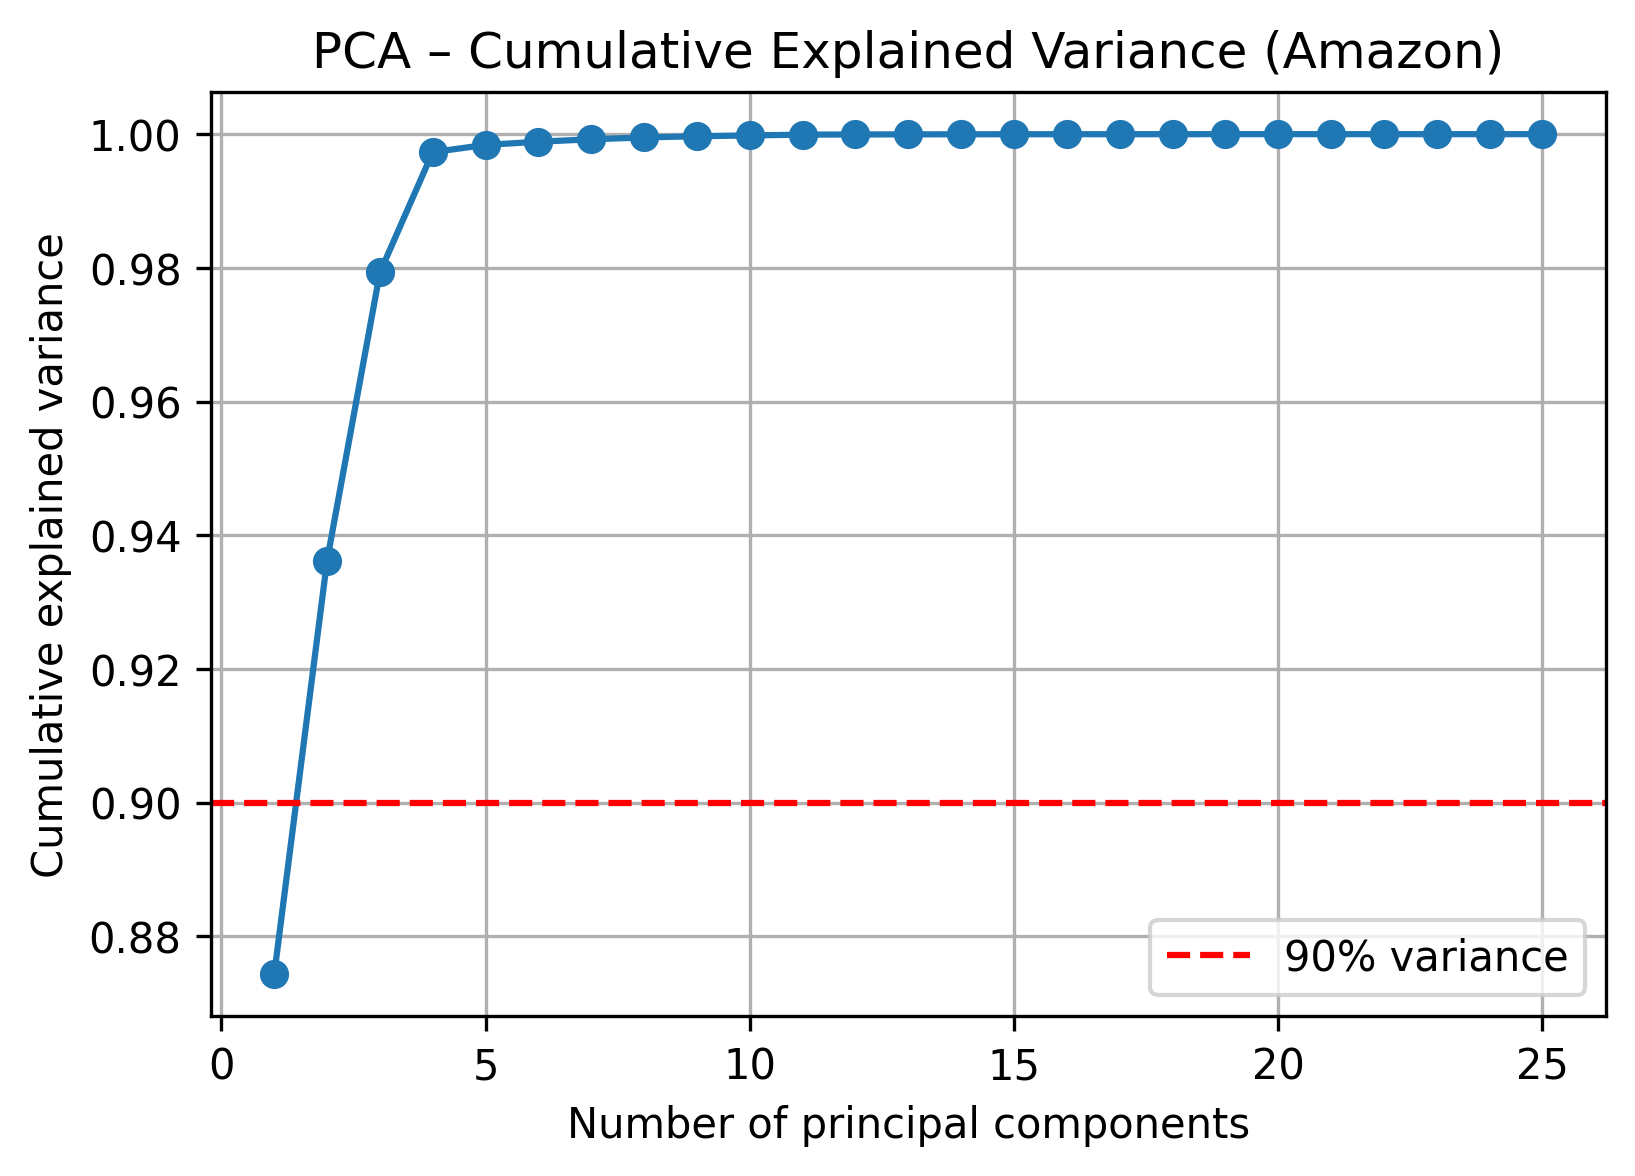

Components needed for 90% variance: 2
Components needed for 95% variance: 3


In [5]:
# Keep enough components to capture most variance (e.g., 50)
n_components = min(50, X.shape[1])
pca = PCA(n_components=n_components, random_state=6220)
X_pca = pca.fit_transform(X)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(6,4))
plt.plot(range(1, n_components+1), cum_explained, marker='o')
plt.axhline(0.90, color='red', linestyle='--', label='90% variance')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA – Cumulative Explained Variance (Amazon)")
plt.grid(True)
plt.legend()
plt.show()

print("Components needed for 90% variance:",
      np.searchsorted(cum_explained, 0.90) + 1)
print("Components needed for 95% variance:",
      np.searchsorted(cum_explained, 0.95) + 1)


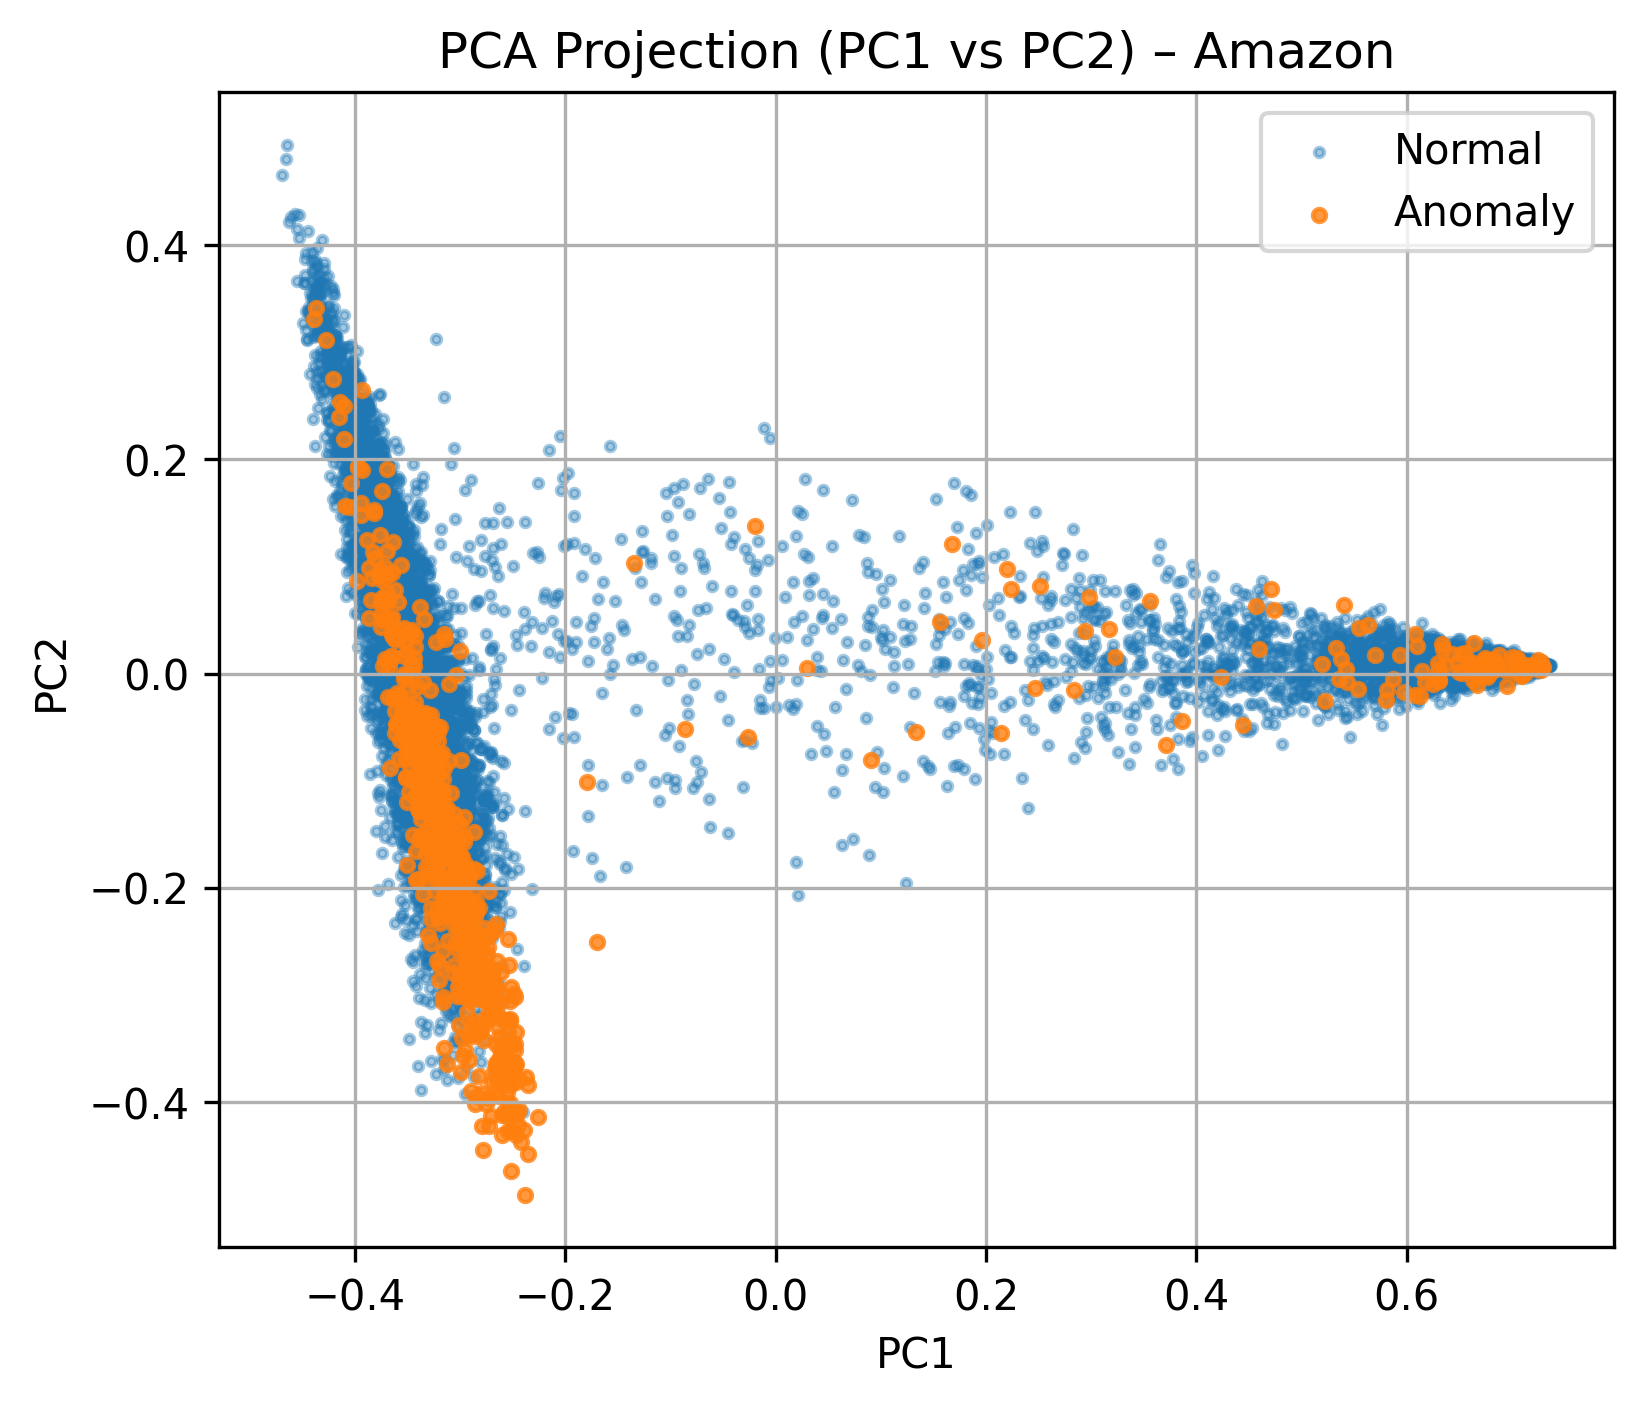

In [6]:
plt.figure(figsize=(6,5))
normal_mask = (y == 0)
anom_mask = (y == 1)

plt.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1],
            s=5, alpha=0.4, label="Normal")
plt.scatter(X_pca[anom_mask, 0], X_pca[anom_mask, 1],
            s=10, alpha=0.8, label="Anomaly")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection (PC1 vs PC2) – Amazon")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Feature indices as "f0", "f1", ...
feature_names = [f"f{i}" for i in range(n_features)]

# Loadings for first principal component
pc1_loadings = pca.components_[0]

# Sort by absolute loading
idx_sorted = np.argsort(np.abs(pc1_loadings))[::-1][:10]

print("Top 10 features contributing to PC1:")
for idx in idx_sorted:
    print(f"{feature_names[idx]:>4}: loading = {pc1_loadings[idx]:.4f}")


Top 10 features contributing to PC1:
 f20: loading = 0.9066
 f23: loading = -0.3547
  f1: loading = -0.1855
 f17: loading = -0.0589
 f19: loading = -0.0584
 f18: loading = -0.0584
 f16: loading = -0.0584
 f15: loading = -0.0582
 f22: loading = -0.0160
 f13: loading = -0.0107


In [8]:
# Supervised ML baselines using anomaly labels as target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=6220, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Anomalies in train:", int(y_train.sum()))
print("Anomalies in test:", int(y_test.sum()))


Train size: 8179
Test size: 2045
Anomalies in train: 554
Anomalies in test: 139


In [9]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=6220,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]

rf_auc = roc_auc_score(y_test, rf_probs)
rf_ap = average_precision_score(y_test, rf_probs)

print(f"RandomForest – AUROC: {rf_auc:.4f}, AUPRC: {rf_ap:.4f}")


RandomForest – AUROC: 0.9799, AUPRC: 0.8733


In [10]:
# IsolationForest: unsupervised anomaly detection
iso = IsolationForest(
    n_estimators=200,
    contamination=float(y.mean()),  # use true anomaly ratio
    random_state=6220,
    n_jobs=-1
)

iso.fit(X_train)  # only features, no labels
# decision_function: higher = more normal, so invert
iso_scores = -iso.decision_function(X_test)

iso_auc = roc_auc_score(y_test, iso_scores)
iso_ap = average_precision_score(y_test, iso_scores)

print(f"IsolationForest – AUROC: {iso_auc:.4f}, AUPRC: {iso_ap:.4f}")


IsolationForest – AUROC: 0.8127, AUPRC: 0.1692


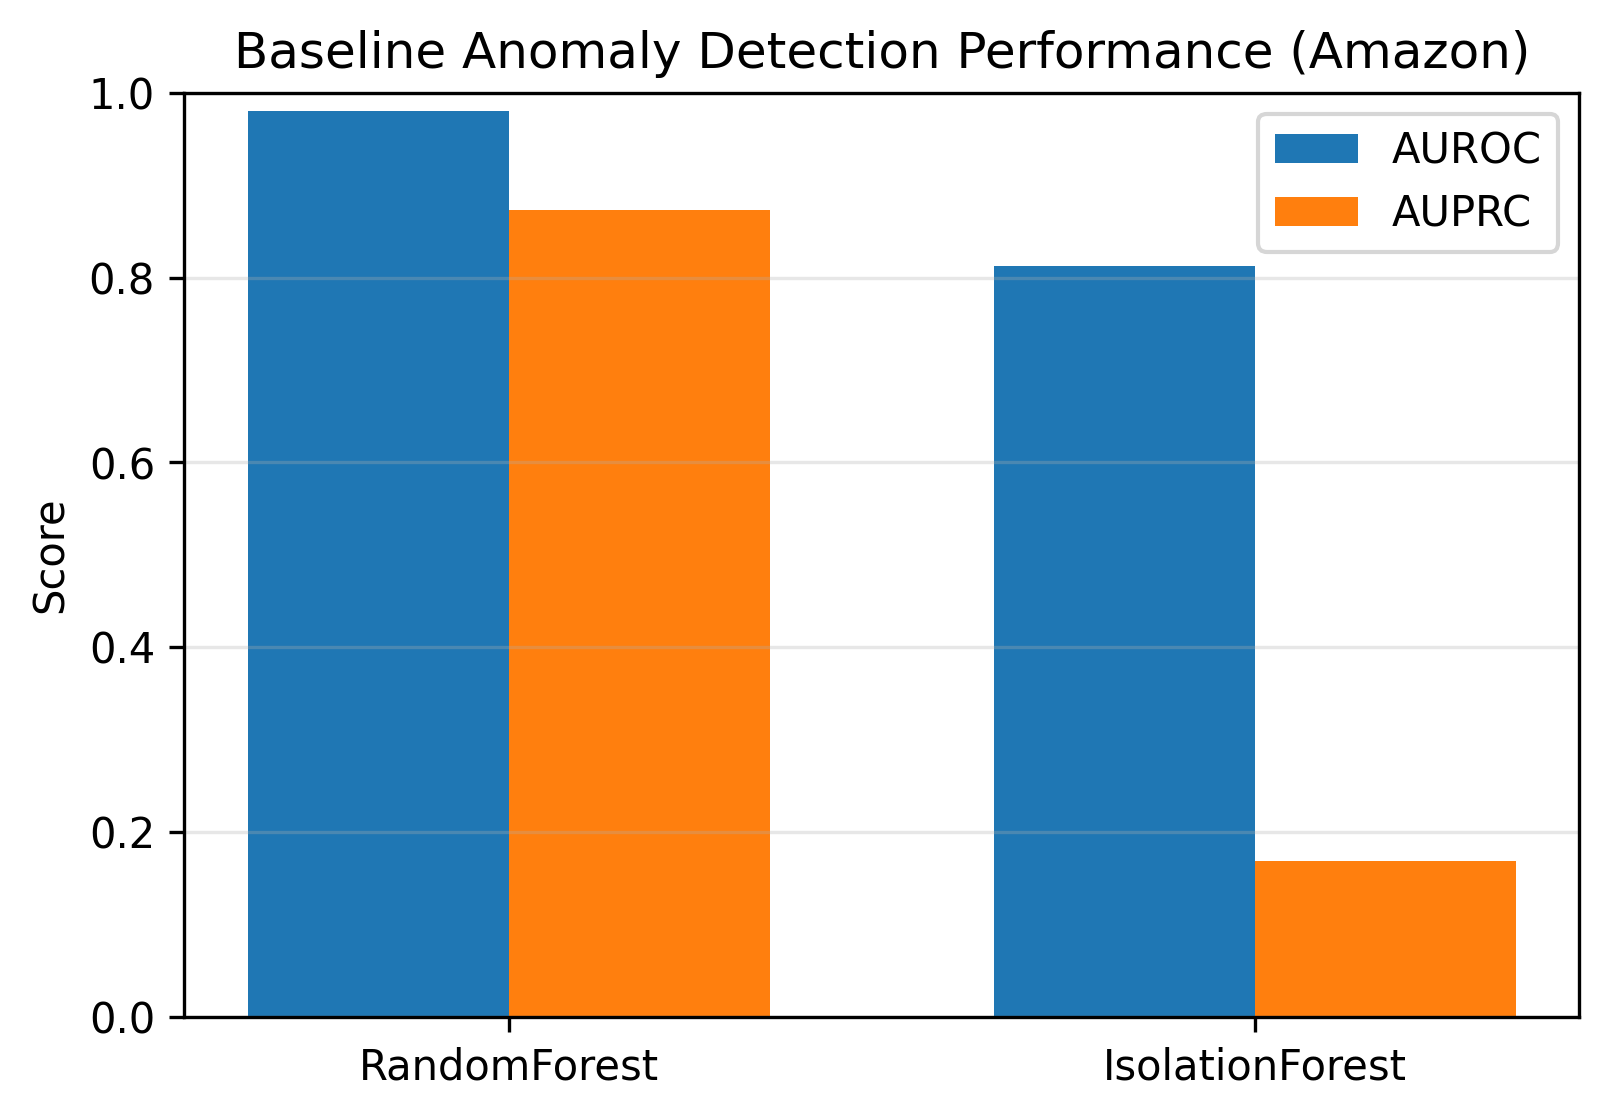

RandomForest     AUROC = 0.9799,  AUPRC = 0.87332714992059123915169038809835910797119141
IsolationForest  AUROC = 0.8127,  AUPRC = 0.16915850360448891898101919650798663496971130


In [11]:
models = ["RandomForest", "IsolationForest"]
aucs = [rf_auc, iso_auc]
aps = [rf_ap, iso_ap]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, aucs, width, label="AUROC")
plt.bar(x + width/2, aps, width, label="AUPRC")
plt.xticks(x, models)
plt.ylim(0.0, 1.0)
plt.ylabel("Score")
plt.title("Baseline Anomaly Detection Performance (Amazon)")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

for name, a, p in zip(models, aucs, aps):
    print(f"{name:15s}  AUROC = {a:.4f},  AUPRC = {p:.44f}")


In [ ]:
## TAM (Truncated Affinity Maximization) – Official Implementation

TAM is implemented in `train.py` and `model.py` in this project folder (`TAM-master`).

To train TAM on the Amazon dataset with the original configuration, run **in a terminal** (not inside the notebook):

```bash
conda activate tam310
cd ~/TAM-master
python train.py --dataset Amazon | tee tam_amazon_log.txt


In [ ]:
import sys
import time

log_file = open("tam_amazon_log.txt", "w")

print("Starting TAM training (Amazon)...")
print("Logging output to tam_amazon_log.txt\n")

# Redirect stdout and stderr
class Tee:
    def __init__(self, *files):
        self.files = files
    def write(self, data):
        for f in self.files:
            f.write(data)
            f.flush()
    def flush(self):
        for f in self.files:
            f.flush()

sys.stdout = Tee(sys.stdout, log_file)
sys.stderr = Tee(sys.stderr, log_file)

start_time = time.time()

# IMPORTANT: run train.py in the SAME kernel
%run train.py --dataset Amazon

end_time = time.time()
print(f"\nTotal training time: {(end_time - start_time)/60:.2f} minutes")

log_file.close()


Starting TAM training (Amazon)...
Logging output to tam_amazon_log.txt

Dataset:  Amazon
Using CUDA


Training:   0%|          | 0/27000 [00:00<?, ?it/s]

<<<<<<Start to calculate distance<<<<<
=== Starting calc_distance ===
calc_distance progress: 0/10224
calc_distance progress: 100/10224
calc_distance progress: 200/10224
calc_distance progress: 300/10224
calc_distance progress: 400/10224
calc_distance progress: 500/10224
calc_distance progress: 600/10224
calc_distance progress: 700/10224
calc_distance progress: 800/10224
calc_distance progress: 900/10224
calc_distance progress: 1000/10224
calc_distance progress: 1100/10224
calc_distance progress: 1200/10224
calc_distance progress: 1300/10224
calc_distance progress: 1400/10224
calc_distance progress: 1500/10224
calc_distance progress: 1600/10224
calc_distance progress: 1700/10224
calc_distance progress: 1800/10224
calc_distance progress: 1900/10224
calc_distance progress: 2000/10224
calc_distance progress: 2100/10224
calc_distance progress: 2200/10224
calc_distance progress: 2300/10224
calc_distance progress: 2400/10224
calc_distance progress: 2500/10224
calc_distance progress: 2600/102

Training:   0%|          | 1/27000 [00:02<21:04:59,  2.81s/it]

mean_loss is -9316.431640625


Training:   0%|          | 49/27000 [00:04<17:56, 25.04it/s]  

mean_loss is -9571.5830078125


Training:   0%|          | 100/27000 [00:06<17:32, 25.56it/s]

mean_loss is -9806.85546875


Training:   1%|          | 151/27000 [00:08<17:38, 25.35it/s]

mean_loss is -9971.560546875


Training:   1%|          | 199/27000 [00:10<17:27, 25.58it/s]

mean_loss is -10073.0625


Training:   1%|          | 250/27000 [00:12<17:26, 25.57it/s]

mean_loss is -10130.6396484375


Training:   1%|1         | 301/27000 [00:14<17:27, 25.48it/s]

mean_loss is -10160.8525390625


Training:   1%|1         | 349/27000 [00:16<17:26, 25.47it/s]

mean_loss is -10174.744140625


Training:   1%|1         | 400/27000 [00:18<17:20, 25.57it/s]

mean_loss is -10179.201171875


Training:   2%|1         | 451/27000 [00:20<17:19, 25.54it/s]

mean_loss is -10178.779296875


Training:   2%|1         | 499/27000 [00:22<17:19, 25.49it/s]

<<<< cutting num .0<<<<<<
mean_loss is -8695.98046875


Training:   2%|2         | 550/27000 [00:26<17:37, 25.02it/s]  

mean_loss is -9098.470703125


Training:   2%|2         | 601/27000 [00:28<17:19, 25.40it/s]

mean_loss is -9490.173828125


Training:   2%|2         | 649/27000 [00:29<17:22, 25.28it/s]

mean_loss is -9773.9140625


Training:   3%|2         | 700/27000 [00:31<17:20, 25.28it/s]

mean_loss is -9956.05859375


Training:   3%|2         | 751/27000 [00:33<17:15, 25.34it/s]

mean_loss is -10064.80859375


Training:   3%|2         | 799/27000 [00:35<17:14, 25.32it/s]

mean_loss is -10126.3671875


Training:   3%|3         | 850/27000 [00:37<17:19, 25.17it/s]

mean_loss is -10159.1953125


Training:   3%|3         | 901/27000 [00:39<17:15, 25.20it/s]

mean_loss is -10175.00390625


Training:   4%|3         | 949/27000 [00:41<17:07, 25.35it/s]

mean_loss is -10181.126953125


Training:   4%|3         | 1000/27000 [00:44<21:57, 19.73it/s]

<<<< cutting num .0<<<<<<
mean_loss is -8768.3779296875


Training:   4%|3         | 1051/27000 [00:47<17:19, 24.95it/s]  

mean_loss is -9130.06640625


Training:   4%|4         | 1099/27000 [00:49<17:05, 25.27it/s]

mean_loss is -9485.740234375


Training:   4%|4         | 1150/27000 [00:51<17:02, 25.28it/s]

mean_loss is -9749.2060546875


Training:   4%|4         | 1201/27000 [00:53<16:51, 25.50it/s]

mean_loss is -9922.71484375


Training:   5%|4         | 1249/27000 [00:55<16:46, 25.59it/s]

mean_loss is -10030.140625


Training:   5%|4         | 1300/27000 [00:57<16:44, 25.58it/s]

mean_loss is -10094.759765625


Training:   5%|5         | 1351/27000 [00:59<16:42, 25.59it/s]

mean_loss is -10132.875


Training:   5%|5         | 1399/27000 [01:01<16:40, 25.59it/s]

mean_loss is -10154.7451171875


Training:   5%|5         | 1450/27000 [01:03<16:38, 25.59it/s]

mean_loss is -10167.03125


Training:   6%|5         | 1498/27000 [01:05<16:38, 25.54it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.6151


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.6141


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.6179


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.19292950116090518
Amazon AUC:0.6288


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.19292950116090518
Amazon AUC:0.6288
n_cut.1
<<<< cutting num .1<<<<<<


Training:   6%|5         | 1501/27000 [01:07<1:28:06,  4.82it/s]

mean_loss is -8398.8134765625


Training:   6%|5         | 1549/27000 [01:09<16:50, 25.18it/s]  

mean_loss is -8849.984375


Training:   6%|5         | 1600/27000 [01:11<16:35, 25.52it/s]

mean_loss is -9300.2548828125


Training:   6%|6         | 1651/27000 [01:13<16:32, 25.54it/s]

mean_loss is -9638.2578125


Training:   6%|6         | 1699/27000 [01:14<16:28, 25.59it/s]

mean_loss is -9862.046875


Training:   6%|6         | 1750/27000 [01:16<16:31, 25.47it/s]

mean_loss is -9997.966796875


Training:   7%|6         | 1801/27000 [01:18<16:28, 25.49it/s]

mean_loss is -10075.900390625


Training:   7%|6         | 1849/27000 [01:20<16:24, 25.55it/s]

mean_loss is -10117.421875


Training:   7%|7         | 1900/27000 [01:22<16:24, 25.49it/s]

mean_loss is -10137.4814453125


Training:   7%|7         | 1951/27000 [01:24<16:20, 25.54it/s]

mean_loss is -10145.74609375


Training:   7%|7         | 1999/27000 [01:26<16:19, 25.53it/s]

<<<< cutting num .1<<<<<<
mean_loss is -7972.88427734375


Training:   8%|7         | 2050/27000 [01:30<16:31, 25.16it/s]  

mean_loss is -8440.51953125


Training:   8%|7         | 2101/27000 [01:32<16:18, 25.43it/s]

mean_loss is -8954.3134765625


Training:   8%|7         | 2149/27000 [01:34<16:15, 25.46it/s]

mean_loss is -9380.400390625


Training:   8%|8         | 2200/27000 [01:36<16:14, 25.46it/s]

mean_loss is -9688.1396484375


Training:   8%|8         | 2251/27000 [01:38<16:13, 25.43it/s]

mean_loss is -9891.6640625


Training:   9%|8         | 2299/27000 [01:39<16:08, 25.49it/s]

mean_loss is -10014.8876953125


Training:   9%|8         | 2350/27000 [01:41<16:08, 25.44it/s]

mean_loss is -10083.8701171875


Training:   9%|8         | 2401/27000 [01:43<16:07, 25.44it/s]

mean_loss is -10120.44140625


Training:   9%|9         | 2449/27000 [01:45<16:02, 25.50it/s]

mean_loss is -10139.6064453125


Training:   9%|9         | 2500/27000 [01:47<16:00, 25.51it/s]

<<<< cutting num .1<<<<<<
mean_loss is -8650.517578125


Training:   9%|9         | 2551/27000 [01:51<16:12, 25.15it/s]  

mean_loss is -9026.267578125


Training:  10%|9         | 2599/27000 [01:53<15:57, 25.48it/s]

mean_loss is -9392.5673828125


Training:  10%|9         | 2650/27000 [01:55<15:57, 25.43it/s]

mean_loss is -9665.953125


Training:  10%|#         | 2701/27000 [01:57<15:54, 25.46it/s]

mean_loss is -9852.9140625


Training:  10%|#         | 2749/27000 [01:59<15:54, 25.41it/s]

mean_loss is -9976.4736328125


Training:  10%|#         | 2800/27000 [02:01<15:49, 25.48it/s]

mean_loss is -10055.873046875


Training:  11%|#         | 2851/27000 [02:03<15:47, 25.48it/s]

mean_loss is -10106.015625


Training:  11%|#         | 2899/27000 [02:05<15:46, 25.46it/s]

mean_loss is -10136.630859375


Training:  11%|#         | 2950/27000 [02:07<15:42, 25.52it/s]

mean_loss is -10154.671875


Training:  11%|#1        | 2998/27000 [02:08<15:40, 25.51it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.6706


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.6894


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.6648


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.3035147768800796
Amazon AUC:0.6883


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.27432548479305263
Amazon AUC:0.6755
n_cut.2
<<<< cutting num .2<<<<<<


Training:  11%|#1        | 3001/27000 [02:10<1:20:27,  4.97it/s]

mean_loss is -7834.42333984375


Training:  11%|#1        | 3049/27000 [02:12<15:52, 25.15it/s]  

mean_loss is -8379.2763671875


Training:  11%|#1        | 3100/27000 [02:14<15:40, 25.41it/s]

mean_loss is -8957.50390625


Training:  12%|#1        | 3151/27000 [02:16<15:35, 25.49it/s]

mean_loss is -9411.4375


Training:  12%|#1        | 3199/27000 [02:18<15:33, 25.48it/s]

mean_loss is -9719.8193359375


Training:  12%|#2        | 3250/27000 [02:20<15:33, 25.43it/s]

mean_loss is -9911.240234375


Training:  12%|#2        | 3301/27000 [02:22<15:31, 25.43it/s]

mean_loss is -10020.138671875


Training:  12%|#2        | 3349/27000 [02:24<15:29, 25.45it/s]

mean_loss is -10075.8583984375


Training:  13%|#2        | 3400/27000 [02:26<15:26, 25.47it/s]

mean_loss is -10103.484375


Training:  13%|#2        | 3451/27000 [02:28<15:24, 25.46it/s]

mean_loss is -10116.869140625


Training:  13%|#2        | 3499/27000 [02:30<15:23, 25.46it/s]

<<<< cutting num .2<<<<<<
mean_loss is -7759.83154296875


Training:  13%|#3        | 3550/27000 [02:33<15:31, 25.17it/s]  

mean_loss is -8283.5625


Training:  13%|#3        | 3601/27000 [02:35<15:19, 25.46it/s]

mean_loss is -8855.4052734375


Training:  14%|#3        | 3649/27000 [02:37<15:16, 25.47it/s]

mean_loss is -9323.0244140625


Training:  14%|#3        | 3700/27000 [02:39<15:15, 25.46it/s]

mean_loss is -9654.3935546875


Training:  14%|#3        | 3751/27000 [02:41<15:16, 25.36it/s]

mean_loss is -9871.009765625


Training:  14%|#4        | 3799/27000 [02:43<15:15, 25.34it/s]

mean_loss is -10001.365234375


Training:  14%|#4        | 3850/27000 [02:45<15:09, 25.45it/s]

mean_loss is -10072.892578125


Training:  14%|#4        | 3901/27000 [02:47<15:07, 25.44it/s]

mean_loss is -10108.080078125


Training:  15%|#4        | 3949/27000 [02:49<15:05, 25.45it/s]

mean_loss is -10124.1435546875


Training:  15%|#4        | 4000/27000 [02:51<15:02, 25.47it/s]

<<<< cutting num .2<<<<<<
mean_loss is -7798.265625


Training:  15%|#5        | 4051/27000 [02:54<15:12, 25.14it/s]  

mean_loss is -8330.95703125


Training:  15%|#5        | 4099/27000 [02:56<15:00, 25.44it/s]

mean_loss is -8894.923828125


Training:  15%|#5        | 4150/27000 [02:58<14:59, 25.40it/s]

mean_loss is -9346.7265625


Training:  16%|#5        | 4201/27000 [03:00<14:56, 25.42it/s]

mean_loss is -9665.8984375


Training:  16%|#5        | 4249/27000 [03:02<14:53, 25.45it/s]

mean_loss is -9873.037109375


Training:  16%|#5        | 4300/27000 [03:04<14:51, 25.46it/s]

mean_loss is -9998.904296875


Training:  16%|#6        | 4351/27000 [03:06<14:51, 25.41it/s]

mean_loss is -10071.12109375


Training:  16%|#6        | 4399/27000 [03:08<14:49, 25.42it/s]

mean_loss is -10111.73828125


Training:  16%|#6        | 4450/27000 [03:10<14:45, 25.47it/s]

mean_loss is -10133.361328125


Training:  17%|#6        | 4498/27000 [03:12<14:44, 25.43it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.7272


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.7313


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.7312


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.4223911008302744
Amazon AUC:0.7368


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.35728277065559244
Amazon AUC:0.7148
n_cut.3
<<<< cutting num .3<<<<<<


Training:  17%|#6        | 4501/27000 [03:14<1:12:19,  5.18it/s]

mean_loss is -7281.96484375


Training:  17%|#6        | 4549/27000 [03:15<14:55, 25.07it/s]  

mean_loss is -7805.69384765625


Training:  17%|#7        | 4600/27000 [03:17<14:39, 25.46it/s]

mean_loss is -8407.0458984375


Training:  17%|#7        | 4651/27000 [03:19<14:39, 25.42it/s]

mean_loss is -8934.21484375


Training:  17%|#7        | 4699/27000 [03:21<14:36, 25.44it/s]

mean_loss is -9341.2529296875


Training:  18%|#7        | 4750/27000 [03:23<14:34, 25.43it/s]

mean_loss is -9630.6396484375


Training:  18%|#7        | 4801/27000 [03:25<14:33, 25.41it/s]

mean_loss is -9823.0068359375


Training:  18%|#7        | 4849/27000 [03:27<14:31, 25.41it/s]

mean_loss is -9946.9619140625


Training:  18%|#8        | 4900/27000 [03:29<14:28, 25.44it/s]

mean_loss is -10025.5419921875


Training:  18%|#8        | 4951/27000 [03:31<14:26, 25.44it/s]

mean_loss is -10074.056640625


Training:  19%|#8        | 4999/27000 [03:33<14:26, 25.39it/s]

<<<< cutting num .3<<<<<<
mean_loss is -7667.59619140625


Training:  19%|#8        | 5050/27000 [03:36<14:32, 25.16it/s]  

mean_loss is -8190.4208984375


Training:  19%|#8        | 5101/27000 [03:38<14:22, 25.39it/s]

mean_loss is -8769.619140625


Training:  19%|#9        | 5149/27000 [03:40<14:18, 25.45it/s]

mean_loss is -9251.2421875


Training:  19%|#9        | 5200/27000 [03:42<14:16, 25.46it/s]

mean_loss is -9597.7109375


Training:  19%|#9        | 5251/27000 [03:44<14:14, 25.47it/s]

mean_loss is -9822.7392578125


Training:  20%|#9        | 5299/27000 [03:46<14:12, 25.46it/s]

mean_loss is -9958.814453125


Training:  20%|#9        | 5350/27000 [03:48<14:10, 25.46it/s]

mean_loss is -10036.02734375


Training:  20%|##        | 5401/27000 [03:50<14:08, 25.47it/s]

mean_loss is -10077.634765625


Training:  20%|##        | 5449/27000 [03:52<14:05, 25.49it/s]

mean_loss is -10099.69140625


Training:  20%|##        | 5500/27000 [03:54<14:05, 25.44it/s]

<<<< cutting num .3<<<<<<
mean_loss is -8021.6416015625


Training:  21%|##        | 5551/27000 [03:58<14:13, 25.12it/s]  

mean_loss is -8482.89453125


Training:  21%|##        | 5599/27000 [03:59<14:01, 25.43it/s]

mean_loss is -8972.837890625


Training:  21%|##        | 5650/27000 [04:01<13:58, 25.46it/s]

mean_loss is -9370.080078125


Training:  21%|##1       | 5701/27000 [04:03<13:55, 25.48it/s]

mean_loss is -9653.9521484375


Training:  21%|##1       | 5749/27000 [04:05<13:55, 25.44it/s]

mean_loss is -9843.0263671875


Training:  21%|##1       | 5800/27000 [04:07<13:52, 25.45it/s]

mean_loss is -9963.201171875


Training:  22%|##1       | 5851/27000 [04:09<13:49, 25.49it/s]

mean_loss is -10035.998046875


Training:  22%|##1       | 5899/27000 [04:11<13:48, 25.48it/s]

mean_loss is -10078.568359375


Training:  22%|##2       | 5950/27000 [04:13<13:45, 25.50it/s]

mean_loss is -10103.9326171875


Training:  22%|##2       | 5998/27000 [04:15<13:44, 25.47it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.7100


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.7402


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.7707


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.40042978349205627
Amazon AUC:0.7521


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.3857335550835019
Amazon AUC:0.7354
n_cut.4
<<<< cutting num .4<<<<<<


Training:  22%|##2       | 6001/27000 [04:17<1:05:30,  5.34it/s]

mean_loss is -7803.94921875


Training:  22%|##2       | 6049/27000 [04:19<13:55, 25.07it/s]  

mean_loss is -8313.431640625


Training:  23%|##2       | 6100/27000 [04:21<13:43, 25.39it/s]

mean_loss is -8862.9453125


Training:  23%|##2       | 6151/27000 [04:23<13:41, 25.37it/s]

mean_loss is -9308.62109375


Training:  23%|##2       | 6199/27000 [04:24<13:38, 25.43it/s]

mean_loss is -9627.7353515625


Training:  23%|##3       | 6250/27000 [04:26<13:35, 25.44it/s]

mean_loss is -9839.287109375


Training:  23%|##3       | 6301/27000 [04:28<13:33, 25.45it/s]

mean_loss is -9972.5986328125


Training:  24%|##3       | 6349/27000 [04:30<13:31, 25.46it/s]

mean_loss is -10052.869140625


Training:  24%|##3       | 6400/27000 [04:32<13:28, 25.49it/s]

mean_loss is -10098.564453125


Training:  24%|##3       | 6451/27000 [04:34<13:27, 25.43it/s]

mean_loss is -10122.79296875


Training:  24%|##4       | 6499/27000 [04:36<13:27, 25.40it/s]

<<<< cutting num .4<<<<<<
mean_loss is -8055.78515625


Training:  24%|##4       | 6550/27000 [04:40<13:45, 24.78it/s]

mean_loss is -8552.322265625


Training:  24%|##4       | 6601/27000 [04:42<13:36, 24.99it/s]

mean_loss is -9065.2685546875


Training:  25%|##4       | 6649/27000 [04:44<13:30, 25.10it/s]

mean_loss is -9461.830078125


Training:  25%|##4       | 6700/27000 [04:46<13:21, 25.33it/s]

mean_loss is -9732.5830078125


Training:  25%|##5       | 6751/27000 [04:48<13:27, 25.09it/s]

mean_loss is -9905.24609375


Training:  25%|##5       | 6799/27000 [04:49<13:20, 25.23it/s]

mean_loss is -10009.916015625


Training:  25%|##5       | 6850/27000 [04:52<13:10, 25.48it/s]

mean_loss is -10070.5517578125


Training:  26%|##5       | 6901/27000 [04:54<13:14, 25.31it/s]

mean_loss is -10103.33203125


Training:  26%|##5       | 6949/27000 [04:55<13:13, 25.27it/s]

mean_loss is -10119.20703125


Training:  26%|##5       | 7000/27000 [04:57<13:18, 25.06it/s]

<<<< cutting num .4<<<<<<
mean_loss is -7763.306640625


Training:  26%|##6       | 7051/27000 [05:01<13:19, 24.96it/s]

mean_loss is -8293.76171875


Training:  26%|##6       | 7099/27000 [05:03<13:12, 25.12it/s]

mean_loss is -8855.998046875


Training:  26%|##6       | 7150/27000 [05:05<13:12, 25.04it/s]

mean_loss is -9302.9609375


Training:  27%|##6       | 7201/27000 [05:07<13:08, 25.12it/s]

mean_loss is -9612.4345703125


Training:  27%|##6       | 7249/27000 [05:09<13:03, 25.22it/s]

mean_loss is -9814.685546875


Training:  27%|##7       | 7300/27000 [05:11<13:00, 25.24it/s]

mean_loss is -9942.0458984375


Training:  27%|##7       | 7351/27000 [05:13<13:00, 25.18it/s]

mean_loss is -10021.107421875


Training:  27%|##7       | 7399/27000 [05:15<13:16, 24.60it/s]

mean_loss is -10068.8662109375


Training:  28%|##7       | 7450/27000 [05:17<12:56, 25.18it/s]

mean_loss is -10097.44921875


Training:  28%|##7       | 7498/27000 [05:19<12:55, 25.13it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.7848


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.7912


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.7702


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.45518900297757714
Amazon AUC:0.7899


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.4119853975388267
Amazon AUC:0.7598
n_cut.5
<<<< cutting num .5<<<<<<


Training:  28%|##7       | 7501/27000 [05:20<1:00:55,  5.33it/s]

mean_loss is -7018.16650390625


Training:  28%|##7       | 7549/27000 [05:22<13:02, 24.84it/s]  

mean_loss is -7598.20068359375


Training:  28%|##8       | 7600/27000 [05:24<12:50, 25.19it/s]

mean_loss is -8273.4345703125


Training:  28%|##8       | 7651/27000 [05:26<12:46, 25.24it/s]

mean_loss is -8856.0439453125


Training:  29%|##8       | 7699/27000 [05:28<12:49, 25.08it/s]

mean_loss is -9296.6083984375


Training:  29%|##8       | 7750/27000 [05:30<12:42, 25.24it/s]

mean_loss is -9603.783203125


Training:  29%|##8       | 7801/27000 [05:32<12:41, 25.22it/s]

mean_loss is -9807.1123046875


Training:  29%|##9       | 7849/27000 [05:34<12:40, 25.20it/s]

mean_loss is -9937.88671875


Training:  29%|##9       | 7900/27000 [05:36<12:37, 25.22it/s]

mean_loss is -10019.580078125


Training:  29%|##9       | 7951/27000 [05:38<12:35, 25.20it/s]

mean_loss is -10069.53125


Training:  30%|##9       | 7999/27000 [05:40<12:34, 25.18it/s]

<<<< cutting num .5<<<<<<
mean_loss is -8299.53125


Training:  30%|##9       | 8050/27000 [05:43<12:38, 24.97it/s]

mean_loss is -8770.8828125


Training:  30%|###       | 8101/27000 [05:45<12:29, 25.21it/s]

mean_loss is -9231.166015625


Training:  30%|###       | 8149/27000 [05:47<12:27, 25.22it/s]

mean_loss is -9571.53515625


Training:  30%|###       | 8200/27000 [05:49<12:24, 25.26it/s]

mean_loss is -9794.5595703125


Training:  31%|###       | 8251/27000 [05:51<12:22, 25.24it/s]

mean_loss is -9932.43359375


Training:  31%|###       | 8299/27000 [05:53<12:20, 25.26it/s]

mean_loss is -10014.87890625


Training:  31%|###       | 8350/27000 [05:55<12:19, 25.22it/s]

mean_loss is -10063.88671875


Training:  31%|###1      | 8401/27000 [05:57<12:16, 25.26it/s]

mean_loss is -10093.283203125


Training:  31%|###1      | 8449/27000 [05:59<12:16, 25.17it/s]

mean_loss is -10110.9365234375


Training:  31%|###1      | 8500/27000 [06:01<12:12, 25.25it/s]

<<<< cutting num .5<<<<<<
mean_loss is -8185.640625


Training:  32%|###1      | 8551/27000 [06:05<12:18, 24.97it/s]

mean_loss is -8617.6787109375


Training:  32%|###1      | 8599/27000 [06:07<12:11, 25.15it/s]

mean_loss is -9070.5302734375


Training:  32%|###2      | 8650/27000 [06:09<12:08, 25.20it/s]

mean_loss is -9435.79296875


Training:  32%|###2      | 8701/27000 [06:11<12:05, 25.22it/s]

mean_loss is -9696.509765625


Training:  32%|###2      | 8749/27000 [06:12<12:04, 25.20it/s]

mean_loss is -9869.322265625


Training:  33%|###2      | 8800/27000 [06:15<12:01, 25.24it/s]

mean_loss is -9977.1396484375


Training:  33%|###2      | 8851/27000 [06:17<11:59, 25.24it/s]

mean_loss is -10042.3203125


Training:  33%|###2      | 8899/27000 [06:18<11:57, 25.22it/s]

mean_loss is -10081.4970703125


Training:  33%|###3      | 8950/27000 [06:20<11:54, 25.27it/s]

mean_loss is -10104.779296875


Training:  33%|###3      | 8998/27000 [06:22<11:53, 25.23it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8382


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8360


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8243


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.586354587261819
Amazon AUC:0.8368


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.4607216115935201
Amazon AUC:0.7910
n_cut.6
<<<< cutting num .6<<<<<<


Training:  33%|###3      | 9001/27000 [06:24<54:46,  5.48it/s]

mean_loss is -7511.439453125


Training:  34%|###3      | 9049/27000 [06:26<12:04, 24.77it/s]

mean_loss is -8071.56298828125


Training:  34%|###3      | 9100/27000 [06:28<11:50, 25.20it/s]

mean_loss is -8685.0830078125


Training:  34%|###3      | 9151/27000 [06:30<11:50, 25.14it/s]

mean_loss is -9189.607421875


Training:  34%|###4      | 9199/27000 [06:32<11:49, 25.08it/s]

mean_loss is -9555.1767578125


Training:  34%|###4      | 9250/27000 [06:34<11:44, 25.18it/s]

mean_loss is -9793.1748046875


Training:  34%|###4      | 9301/27000 [06:36<11:43, 25.14it/s]

mean_loss is -9937.6484375


Training:  35%|###4      | 9349/27000 [06:38<11:41, 25.15it/s]

mean_loss is -10023.98046875


Training:  35%|###4      | 9400/27000 [06:40<11:39, 25.16it/s]

mean_loss is -10073.6171875


Training:  35%|###5      | 9451/27000 [06:42<11:37, 25.15it/s]

mean_loss is -10101.845703125


Training:  35%|###5      | 9499/27000 [06:44<11:34, 25.19it/s]

<<<< cutting num .6<<<<<<
mean_loss is -7735.8408203125


Training:  35%|###5      | 9550/27000 [06:47<11:40, 24.92it/s]

mean_loss is -8273.0322265625


Training:  36%|###5      | 9601/27000 [06:49<11:30, 25.21it/s]

mean_loss is -8844.640625


Training:  36%|###5      | 9649/27000 [06:51<11:32, 25.07it/s]

mean_loss is -9297.54296875


Training:  36%|###5      | 9700/27000 [06:53<11:27, 25.15it/s]

mean_loss is -9609.197265625


Training:  36%|###6      | 9751/27000 [06:55<11:25, 25.17it/s]

mean_loss is -9809.28515625


Training:  36%|###6      | 9799/27000 [06:57<11:24, 25.13it/s]

mean_loss is -9933.5986328125


Training:  36%|###6      | 9850/27000 [06:59<11:21, 25.17it/s]

mean_loss is -10008.7890625


Training:  37%|###6      | 9901/27000 [07:01<11:18, 25.20it/s]

mean_loss is -10054.318359375


Training:  37%|###6      | 9949/27000 [07:03<11:18, 25.15it/s]

mean_loss is -10083.0205078125


Training:  37%|###7      | 10000/27000 [07:05<11:14, 25.19it/s]

<<<< cutting num .6<<<<<<
mean_loss is -7160.76806640625


Training:  37%|###7      | 10051/27000 [07:08<11:18, 24.96it/s]

mean_loss is -7682.7197265625


Training:  37%|###7      | 10099/27000 [07:10<11:13, 25.09it/s]

mean_loss is -8307.12890625


Training:  38%|###7      | 10150/27000 [07:12<11:08, 25.19it/s]

mean_loss is -8865.3408203125


Training:  38%|###7      | 10201/27000 [07:14<11:07, 25.18it/s]

mean_loss is -9305.328125


Training:  38%|###7      | 10249/27000 [07:16<11:06, 25.13it/s]

mean_loss is -9617.2412109375


Training:  38%|###8      | 10300/27000 [07:18<11:02, 25.21it/s]

mean_loss is -9822.21875


Training:  38%|###8      | 10351/27000 [07:20<11:00, 25.20it/s]

mean_loss is -9950.708984375


Training:  39%|###8      | 10399/27000 [07:22<10:59, 25.16it/s]

mean_loss is -10028.392578125


Training:  39%|###8      | 10450/27000 [07:24<10:56, 25.19it/s]

mean_loss is -10073.32421875


Training:  39%|###8      | 10498/27000 [07:26<10:56, 25.14it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8017


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8401


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8347


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.5326955117236668
Amazon AUC:0.8313


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.4827179411801704
Amazon AUC:0.8067
n_cut.7
<<<< cutting num .7<<<<<<


Training:  39%|###8      | 10501/27000 [07:27<49:25,  5.56it/s]

mean_loss is -7482.0322265625


Training:  39%|###9      | 10549/27000 [07:29<11:01, 24.88it/s]

mean_loss is -8007.6962890625


Training:  39%|###9      | 10600/27000 [07:31<10:49, 25.25it/s]

mean_loss is -8589.1611328125


Training:  39%|###9      | 10651/27000 [07:33<10:47, 25.24it/s]

mean_loss is -9069.5146484375


Training:  40%|###9      | 10699/27000 [07:35<10:47, 25.16it/s]

mean_loss is -9424.8359375


Training:  40%|###9      | 10750/27000 [07:37<10:44, 25.22it/s]

mean_loss is -9669.837890625


Training:  40%|####      | 10801/27000 [07:39<10:41, 25.23it/s]

mean_loss is -9835.9482421875


Training:  40%|####      | 10849/27000 [07:41<10:41, 25.20it/s]

mean_loss is -9947.9921875


Training:  40%|####      | 10900/27000 [07:43<10:36, 25.29it/s]

mean_loss is -10022.658203125


Training:  41%|####      | 10951/27000 [07:45<10:34, 25.28it/s]

mean_loss is -10071.5341796875


Training:  41%|####      | 10999/27000 [07:47<10:34, 25.21it/s]

<<<< cutting num .7<<<<<<
mean_loss is -7414.119140625


Training:  41%|####      | 11050/27000 [07:50<10:38, 24.97it/s]

mean_loss is -7993.107421875


Training:  41%|####1     | 11101/27000 [07:52<10:31, 25.19it/s]

mean_loss is -8636.4111328125


Training:  41%|####1     | 11149/27000 [07:54<10:29, 25.17it/s]

mean_loss is -9156.0546875


Training:  41%|####1     | 11200/27000 [07:56<10:26, 25.24it/s]

mean_loss is -9523.111328125


Training:  42%|####1     | 11251/27000 [07:58<10:27, 25.11it/s]

mean_loss is -9763.810546875


Training:  42%|####1     | 11299/27000 [08:00<10:23, 25.19it/s]

mean_loss is -9914.884765625


Training:  42%|####2     | 11350/27000 [08:02<10:21, 25.20it/s]

mean_loss is -10005.76171875


Training:  42%|####2     | 11401/27000 [08:04<10:20, 25.12it/s]

mean_loss is -10058.8994140625


Training:  42%|####2     | 11449/27000 [08:06<10:18, 25.14it/s]

mean_loss is -10088.791015625


Training:  43%|####2     | 11500/27000 [08:08<10:15, 25.19it/s]

<<<< cutting num .7<<<<<<
mean_loss is -7023.21240234375


Training:  43%|####2     | 11551/27000 [08:12<10:18, 24.96it/s]

mean_loss is -7536.205078125


Training:  43%|####2     | 11599/27000 [08:14<10:12, 25.15it/s]

mean_loss is -8153.0478515625


Training:  43%|####3     | 11650/27000 [08:16<10:09, 25.20it/s]

mean_loss is -8712.2939453125


Training:  43%|####3     | 11701/27000 [08:18<10:08, 25.16it/s]

mean_loss is -9160.001953125


Training:  44%|####3     | 11749/27000 [08:19<10:06, 25.17it/s]

mean_loss is -9491.744140625


Training:  44%|####3     | 11800/27000 [08:22<10:02, 25.24it/s]

mean_loss is -9722.2041015625


Training:  44%|####3     | 11851/27000 [08:24<10:00, 25.21it/s]

mean_loss is -9875.1748046875


Training:  44%|####4     | 11899/27000 [08:25<09:59, 25.17it/s]

mean_loss is -9973.60546875


Training:  44%|####4     | 11950/27000 [08:27<09:57, 25.19it/s]

mean_loss is -10034.310546875


Training:  44%|####4     | 11998/27000 [08:29<09:54, 25.23it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8473


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8312


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8406


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.5705304893338164
Amazon AUC:0.8413


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.5054098160740342
Amazon AUC:0.8207
n_cut.8
<<<< cutting num .8<<<<<<


Training:  44%|####4     | 12001/27000 [08:31<44:09,  5.66it/s]

mean_loss is -6971.08251953125


Training:  45%|####4     | 12049/27000 [08:33<10:02, 24.80it/s]

mean_loss is -7463.283203125


Training:  45%|####4     | 12100/27000 [08:35<09:52, 25.15it/s]

mean_loss is -8063.7880859375


Training:  45%|####5     | 12151/27000 [08:37<09:48, 25.21it/s]

mean_loss is -8624.482421875


Training:  45%|####5     | 12199/27000 [08:39<09:48, 25.13it/s]

mean_loss is -9085.763671875


Training:  45%|####5     | 12250/27000 [08:41<09:44, 25.22it/s]

mean_loss is -9435.0703125


Training:  46%|####5     | 12301/27000 [08:43<09:42, 25.22it/s]

mean_loss is -9682.224609375


Training:  46%|####5     | 12349/27000 [08:45<09:42, 25.16it/s]

mean_loss is -9848.9912109375


Training:  46%|####5     | 12400/27000 [08:47<09:38, 25.23it/s]

mean_loss is -9959.0625


Training:  46%|####6     | 12451/27000 [08:49<09:36, 25.26it/s]

mean_loss is -10029.392578125


Training:  46%|####6     | 12499/27000 [08:51<09:35, 25.18it/s]

<<<< cutting num .8<<<<<<
mean_loss is -7242.529296875


Training:  46%|####6     | 12550/27000 [08:54<09:38, 24.96it/s]

mean_loss is -7777.65234375


Training:  47%|####6     | 12601/27000 [08:56<09:31, 25.18it/s]

mean_loss is -8386.1025390625


Training:  47%|####6     | 12649/27000 [08:58<09:30, 25.15it/s]

mean_loss is -8914.8544921875


Training:  47%|####7     | 12700/27000 [09:00<09:27, 25.18it/s]

mean_loss is -9317.8994140625


Training:  47%|####7     | 12751/27000 [09:02<09:25, 25.21it/s]

mean_loss is -9606.5068359375


Training:  47%|####7     | 12799/27000 [09:04<09:24, 25.16it/s]

mean_loss is -9802.203125


Training:  48%|####7     | 12850/27000 [09:06<09:21, 25.22it/s]

mean_loss is -9930.5458984375


Training:  48%|####7     | 12901/27000 [09:08<09:20, 25.14it/s]

mean_loss is -10012.609375


Training:  48%|####7     | 12949/27000 [09:10<09:18, 25.18it/s]

mean_loss is -10064.3974609375


Training:  48%|####8     | 13000/27000 [09:12<09:15, 25.22it/s]

<<<< cutting num .8<<<<<<
mean_loss is -7010.41357421875


Training:  48%|####8     | 13051/27000 [09:15<09:18, 24.96it/s]

mean_loss is -7578.2880859375


Training:  49%|####8     | 13099/27000 [09:17<09:12, 25.14it/s]

mean_loss is -8255.306640625


Training:  49%|####8     | 13150/27000 [09:19<09:09, 25.22it/s]

mean_loss is -8858.6953125


Training:  49%|####8     | 13201/27000 [09:21<09:07, 25.21it/s]

mean_loss is -9308.376953125


Training:  49%|####9     | 13249/27000 [09:23<09:06, 25.16it/s]

mean_loss is -9615.119140625


Training:  49%|####9     | 13300/27000 [09:25<09:03, 25.22it/s]

mean_loss is -9813.6923828125


Training:  49%|####9     | 13351/27000 [09:27<09:00, 25.23it/s]

mean_loss is -9937.984375


Training:  50%|####9     | 13399/27000 [09:29<09:01, 25.13it/s]

mean_loss is -10014.404296875


Training:  50%|####9     | 13450/27000 [09:31<08:56, 25.24it/s]

mean_loss is -10060.005859375


Training:  50%|####9     | 13498/27000 [09:33<08:55, 25.20it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8155


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8631


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8510


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.5912276527162056
Amazon AUC:0.8475


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.5243176078512745
Amazon AUC:0.8300
n_cut.9
<<<< cutting num .9<<<<<<


Training:  50%|#####     | 13501/27000 [09:34<39:30,  5.69it/s]

mean_loss is -7911.10693359375


Training:  50%|#####     | 13549/27000 [09:36<09:00, 24.89it/s]

mean_loss is -8374.1328125


Training:  50%|#####     | 13600/27000 [09:38<08:51, 25.20it/s]

mean_loss is -8870.9921875


Training:  51%|#####     | 13651/27000 [09:40<08:50, 25.18it/s]

mean_loss is -9272.77734375


Training:  51%|#####     | 13699/27000 [09:42<08:48, 25.17it/s]

mean_loss is -9569.15625


Training:  51%|#####     | 13750/27000 [09:44<08:46, 25.18it/s]

mean_loss is -9775.669921875


Training:  51%|#####1    | 13801/27000 [09:46<08:43, 25.22it/s]

mean_loss is -9911.8056640625


Training:  51%|#####1    | 13849/27000 [09:48<08:42, 25.17it/s]

mean_loss is -9998.2548828125


Training:  51%|#####1    | 13900/27000 [09:50<08:38, 25.26it/s]

mean_loss is -10051.3388671875


Training:  52%|#####1    | 13951/27000 [09:52<08:36, 25.28it/s]

mean_loss is -10082.251953125


Training:  52%|#####1    | 13999/27000 [09:54<08:35, 25.23it/s]

<<<< cutting num .9<<<<<<
mean_loss is -8007.572265625


Training:  52%|#####2    | 14050/27000 [09:57<08:38, 24.97it/s]

mean_loss is -8478.11328125


Training:  52%|#####2    | 14101/27000 [09:59<08:32, 25.15it/s]

mean_loss is -8965.5244140625


Training:  52%|#####2    | 14149/27000 [10:01<08:30, 25.17it/s]

mean_loss is -9350.0146484375


Training:  53%|#####2    | 14200/27000 [10:03<08:27, 25.22it/s]

mean_loss is -9622.943359375


Training:  53%|#####2    | 14251/27000 [10:05<08:26, 25.17it/s]

mean_loss is -9804.736328125


Training:  53%|#####2    | 14299/27000 [10:07<08:24, 25.19it/s]

mean_loss is -9922.7880859375


Training:  53%|#####3    | 14350/27000 [10:09<08:21, 25.22it/s]

mean_loss is -9998.353515625


Training:  53%|#####3    | 14401/27000 [10:11<08:19, 25.25it/s]

mean_loss is -10046.216796875


Training:  54%|#####3    | 14449/27000 [10:13<08:17, 25.22it/s]

mean_loss is -10076.857421875


Training:  54%|#####3    | 14500/27000 [10:15<08:14, 25.25it/s]

<<<< cutting num .9<<<<<<
mean_loss is -7152.630859375


Training:  54%|#####3    | 14551/27000 [10:18<08:19, 24.92it/s]

mean_loss is -7713.94921875


Training:  54%|#####4    | 14599/27000 [10:20<08:13, 25.13it/s]

mean_loss is -8362.91015625


Training:  54%|#####4    | 14650/27000 [10:22<08:10, 25.17it/s]

mean_loss is -8932.6376953125


Training:  54%|#####4    | 14701/27000 [10:24<08:09, 25.15it/s]

mean_loss is -9360.7880859375


Training:  55%|#####4    | 14749/27000 [10:26<08:06, 25.17it/s]

mean_loss is -9652.7900390625


Training:  55%|#####4    | 14800/27000 [10:28<08:04, 25.20it/s]

mean_loss is -9839.82421875


Training:  55%|#####5    | 14851/27000 [10:30<08:01, 25.21it/s]

mean_loss is -9952.98046875


Training:  55%|#####5    | 14899/27000 [10:32<08:00, 25.19it/s]

mean_loss is -10018.501953125


Training:  55%|#####5    | 14950/27000 [10:34<07:58, 25.20it/s]

mean_loss is -10054.6884765625


Training:  56%|#####5    | 14998/27000 [10:36<07:56, 25.20it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8375


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8614


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8323


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.592470830005703
Amazon AUC:0.8467


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.5390539313723177
Amazon AUC:0.8357
n_cut.10
<<<< cutting num .10<<<<<<


Training:  56%|#####5    | 15001/27000 [10:38<34:43,  5.76it/s]

mean_loss is -7366.0087890625


Training:  56%|#####5    | 15049/27000 [10:39<08:00, 24.88it/s]

mean_loss is -7888.248046875


Training:  56%|#####5    | 15100/27000 [10:41<07:52, 25.17it/s]

mean_loss is -8489.544921875


Training:  56%|#####6    | 15151/27000 [10:44<07:51, 25.15it/s]

mean_loss is -9002.833984375


Training:  56%|#####6    | 15199/27000 [10:45<07:48, 25.17it/s]

mean_loss is -9391.17578125


Training:  56%|#####6    | 15250/27000 [10:47<07:46, 25.19it/s]

mean_loss is -9661.654296875


Training:  57%|#####6    | 15301/27000 [10:49<07:45, 25.16it/s]

mean_loss is -9839.96875


Training:  57%|#####6    | 15349/27000 [10:51<07:42, 25.19it/s]

mean_loss is -9953.220703125


Training:  57%|#####7    | 15400/27000 [10:53<07:39, 25.22it/s]

mean_loss is -10022.3623046875


Training:  57%|#####7    | 15451/27000 [10:55<07:37, 25.22it/s]

mean_loss is -10063.904296875


Training:  57%|#####7    | 15499/27000 [10:57<07:36, 25.20it/s]

<<<< cutting num .10<<<<<<
mean_loss is -7481.466796875


Training:  58%|#####7    | 15550/27000 [11:01<07:38, 24.99it/s]

mean_loss is -7961.0634765625


Training:  58%|#####7    | 15601/27000 [11:03<07:32, 25.18it/s]

mean_loss is -8516.4609375


Training:  58%|#####7    | 15649/27000 [11:04<07:31, 25.11it/s]

mean_loss is -9001.900390625


Training:  58%|#####8    | 15700/27000 [11:06<07:28, 25.19it/s]

mean_loss is -9377.375


Training:  58%|#####8    | 15751/27000 [11:09<07:27, 25.14it/s]

mean_loss is -9647.1943359375


Training:  59%|#####8    | 15799/27000 [11:10<07:24, 25.18it/s]

mean_loss is -9831.78515625


Training:  59%|#####8    | 15850/27000 [11:12<07:22, 25.19it/s]

mean_loss is -9953.81640625


Training:  59%|#####8    | 15901/27000 [11:15<07:21, 25.15it/s]

mean_loss is -10032.1015625


Training:  59%|#####9    | 15949/27000 [11:16<07:18, 25.20it/s]

mean_loss is -10080.71875


Training:  59%|#####9    | 16000/27000 [11:18<07:15, 25.26it/s]

<<<< cutting num .10<<<<<<
mean_loss is -7243.72119140625


Training:  59%|#####9    | 16051/27000 [11:22<07:19, 24.91it/s]

mean_loss is -7751.5380859375


Training:  60%|#####9    | 16099/27000 [11:24<07:13, 25.17it/s]

mean_loss is -8333.37890625


Training:  60%|#####9    | 16150/27000 [11:26<07:10, 25.21it/s]

mean_loss is -8846.0546875


Training:  60%|######    | 16201/27000 [11:28<07:08, 25.22it/s]

mean_loss is -9251.67578125


Training:  60%|######    | 16249/27000 [11:29<07:06, 25.19it/s]

mean_loss is -9549.32421875


Training:  60%|######    | 16300/27000 [11:32<07:04, 25.23it/s]

mean_loss is -9757.619140625


Training:  61%|######    | 16351/27000 [11:34<07:02, 25.20it/s]

mean_loss is -9897.78125


Training:  61%|######    | 16399/27000 [11:35<07:00, 25.21it/s]

mean_loss is -9988.1865234375


Training:  61%|######    | 16450/27000 [11:37<06:58, 25.20it/s]

mean_loss is -10043.853515625


Training:  61%|######1   | 16498/27000 [11:39<06:55, 25.26it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8143


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8337


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8516


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.5578292257498353
Amazon AUC:0.8379


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.5467530806917739
Amazon AUC:0.8381
n_cut.11
<<<< cutting num .11<<<<<<


Training:  61%|######1   | 16501/27000 [11:41<30:25,  5.75it/s]

mean_loss is -7194.2412109375


Training:  61%|######1   | 16549/27000 [11:43<07:00, 24.85it/s]

mean_loss is -7713.1640625


Training:  61%|######1   | 16600/27000 [11:45<06:52, 25.21it/s]

mean_loss is -8310.76171875


Training:  62%|######1   | 16651/27000 [11:47<06:51, 25.13it/s]

mean_loss is -8838.234375


Training:  62%|######1   | 16699/27000 [11:49<06:50, 25.12it/s]

mean_loss is -9251.5927734375


Training:  62%|######2   | 16750/27000 [11:51<06:47, 25.15it/s]

mean_loss is -9552.2626953125


Training:  62%|######2   | 16801/27000 [11:53<06:44, 25.19it/s]

mean_loss is -9762.3896484375


Training:  62%|######2   | 16849/27000 [11:55<06:44, 25.10it/s]

mean_loss is -9904.2275390625


Training:  63%|######2   | 16900/27000 [11:57<06:41, 25.14it/s]

mean_loss is -9996.861328125


Training:  63%|######2   | 16951/27000 [11:59<06:39, 25.13it/s]

mean_loss is -10056.513671875


Training:  63%|######2   | 16999/27000 [12:01<06:37, 25.17it/s]

<<<< cutting num .11<<<<<<
mean_loss is -7795.0927734375


Training:  63%|######3   | 17050/27000 [12:04<06:38, 24.95it/s]

mean_loss is -8283.275390625


Training:  63%|######3   | 17101/27000 [12:06<06:33, 25.16it/s]

mean_loss is -8808.75


Training:  64%|######3   | 17149/27000 [12:08<06:32, 25.07it/s]

mean_loss is -9238.208984375


Training:  64%|######3   | 17200/27000 [12:10<06:29, 25.16it/s]

mean_loss is -9550.0263671875


Training:  64%|######3   | 17251/27000 [12:12<06:27, 25.19it/s]

mean_loss is -9761.2138671875


Training:  64%|######4   | 17299/27000 [12:14<06:26, 25.12it/s]

mean_loss is -9897.7373046875


Training:  64%|######4   | 17350/27000 [12:16<06:23, 25.20it/s]

mean_loss is -9983.666015625


Training:  64%|######4   | 17401/27000 [12:18<06:20, 25.21it/s]

mean_loss is -10038.8466796875


Training:  65%|######4   | 17449/27000 [12:20<06:20, 25.13it/s]

mean_loss is -10075.28125


Training:  65%|######4   | 17500/27000 [12:22<06:16, 25.24it/s]

<<<< cutting num .11<<<<<<
mean_loss is -7766.30419921875


Training:  65%|######5   | 17551/27000 [12:25<06:19, 24.88it/s]

mean_loss is -8269.1064453125


Training:  65%|######5   | 17599/27000 [12:27<06:13, 25.14it/s]

mean_loss is -8810.810546875


Training:  65%|######5   | 17650/27000 [12:29<06:12, 25.12it/s]

mean_loss is -9251.24609375


Training:  66%|######5   | 17701/27000 [12:31<06:09, 25.19it/s]

mean_loss is -9569.6806640625


Training:  66%|######5   | 17749/27000 [12:33<06:07, 25.18it/s]

mean_loss is -9784.9716796875


Training:  66%|######5   | 17800/27000 [12:35<06:06, 25.13it/s]

mean_loss is -9924.158203125


Training:  66%|######6   | 17851/27000 [12:37<06:03, 25.16it/s]

mean_loss is -10010.984375


Training:  66%|######6   | 17899/27000 [12:39<06:01, 25.15it/s]

mean_loss is -10063.240234375


Training:  66%|######6   | 17950/27000 [12:41<05:59, 25.15it/s]

mean_loss is -10093.7705078125


Training:  67%|######6   | 17998/27000 [12:43<05:57, 25.22it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8298


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8448


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8269


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.5317538854472131
Amazon AUC:0.8363


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.5496304115618433
Amazon AUC:0.8398
n_cut.12
<<<< cutting num .12<<<<<<


Training:  67%|######6   | 18001/27000 [12:44<25:41,  5.84it/s]

mean_loss is -7131.6728515625


Training:  67%|######6   | 18049/27000 [12:46<05:59, 24.88it/s]

mean_loss is -7622.916015625


Training:  67%|######7   | 18100/27000 [12:48<05:53, 25.15it/s]

mean_loss is -8199.603515625


Training:  67%|######7   | 18151/27000 [12:50<05:51, 25.17it/s]

mean_loss is -8728.1875


Training:  67%|######7   | 18199/27000 [12:52<05:50, 25.13it/s]

mean_loss is -9166.755859375


Training:  68%|######7   | 18250/27000 [12:54<05:47, 25.20it/s]

mean_loss is -9497.7431640625


Training:  68%|######7   | 18301/27000 [12:56<05:44, 25.26it/s]

mean_loss is -9729.62109375


Training:  68%|######7   | 18349/27000 [12:58<05:43, 25.19it/s]

mean_loss is -9884.2919921875


Training:  68%|######8   | 18400/27000 [13:00<05:41, 25.21it/s]

mean_loss is -9983.81640625


Training:  68%|######8   | 18451/27000 [13:02<05:39, 25.15it/s]

mean_loss is -10046.056640625


Training:  69%|######8   | 18499/27000 [13:04<05:38, 25.13it/s]

<<<< cutting num .12<<<<<<
mean_loss is -7793.88525390625


Training:  69%|######8   | 18550/27000 [13:07<05:39, 24.89it/s]

mean_loss is -8243.3818359375


Training:  69%|######8   | 18601/27000 [13:09<05:33, 25.20it/s]

mean_loss is -8743.5791015625


Training:  69%|######9   | 18649/27000 [13:11<05:33, 25.05it/s]

mean_loss is -9172.01171875


Training:  69%|######9   | 18700/27000 [13:13<05:30, 25.09it/s]

mean_loss is -9497.001953125


Training:  69%|######9   | 18751/27000 [13:15<05:27, 25.17it/s]

mean_loss is -9727.6171875


Training:  70%|######9   | 18799/27000 [13:17<05:26, 25.11it/s]

mean_loss is -9884.623046875


Training:  70%|######9   | 18850/27000 [13:19<05:23, 25.16it/s]

mean_loss is -9987.6962890625


Training:  70%|#######   | 18901/27000 [13:21<05:21, 25.22it/s]

mean_loss is -10052.03125


Training:  70%|#######   | 18949/27000 [13:23<05:20, 25.16it/s]

mean_loss is -10090.828125


Training:  70%|#######   | 19000/27000 [13:25<05:17, 25.18it/s]

<<<< cutting num .12<<<<<<
mean_loss is -7944.2333984375


Training:  71%|#######   | 19051/27000 [13:28<05:19, 24.89it/s]

mean_loss is -8457.255859375


Training:  71%|#######   | 19099/27000 [13:30<05:14, 25.10it/s]

mean_loss is -8982.201171875


Training:  71%|#######   | 19150/27000 [13:32<05:11, 25.20it/s]

mean_loss is -9389.5830078125


Training:  71%|#######1  | 19201/27000 [13:34<05:10, 25.15it/s]

mean_loss is -9671.3203125


Training:  71%|#######1  | 19249/27000 [13:36<05:08, 25.16it/s]

mean_loss is -9854.384765625


Training:  71%|#######1  | 19300/27000 [13:38<05:05, 25.21it/s]

mean_loss is -9968.427734375


Training:  72%|#######1  | 19351/27000 [13:40<05:03, 25.21it/s]

mean_loss is -10036.849609375


Training:  72%|#######1  | 19399/27000 [13:42<05:02, 25.17it/s]

mean_loss is -10076.876953125


Training:  72%|#######2  | 19450/27000 [13:44<04:59, 25.17it/s]

mean_loss is -10100.19921875


Training:  72%|#######2  | 19498/27000 [13:46<04:58, 25.15it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8320


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8338


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8624


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.5790816541905618
Amazon AUC:0.8456


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.555439896768162
Amazon AUC:0.8415
n_cut.13
<<<< cutting num .13<<<<<<


Training:  72%|#######2  | 19501/27000 [13:47<21:08,  5.91it/s]

mean_loss is -7322.8076171875


Training:  72%|#######2  | 19549/27000 [13:49<04:59, 24.90it/s]

mean_loss is -7861.0380859375


Training:  73%|#######2  | 19600/27000 [13:51<04:53, 25.19it/s]

mean_loss is -8468.056640625


Training:  73%|#######2  | 19651/27000 [13:53<04:51, 25.24it/s]

mean_loss is -8984.0048828125


Training:  73%|#######2  | 19699/27000 [13:55<04:50, 25.16it/s]

mean_loss is -9374.1806640625


Training:  73%|#######3  | 19750/27000 [13:57<04:47, 25.24it/s]

mean_loss is -9650.64453125


Training:  73%|#######3  | 19801/27000 [13:59<04:45, 25.18it/s]

mean_loss is -9835.556640625


Training:  74%|#######3  | 19849/27000 [14:01<04:43, 25.22it/s]

mean_loss is -9954.94140625


Training:  74%|#######3  | 19900/27000 [14:03<04:41, 25.22it/s]

mean_loss is -10030.4150390625


Training:  74%|#######3  | 19951/27000 [14:05<04:40, 25.14it/s]

mean_loss is -10076.9208984375


Training:  74%|#######4  | 19999/27000 [14:07<04:37, 25.19it/s]

<<<< cutting num .13<<<<<<
mean_loss is -7758.095703125


Training:  74%|#######4  | 20050/27000 [14:10<04:38, 24.91it/s]

mean_loss is -8224.0810546875


Training:  74%|#######4  | 20101/27000 [14:12<04:33, 25.18it/s]

mean_loss is -8737.1533203125


Training:  75%|#######4  | 20149/27000 [14:14<04:32, 25.16it/s]

mean_loss is -9174.71484375


Training:  75%|#######4  | 20200/27000 [14:16<04:30, 25.12it/s]

mean_loss is -9505.9814453125


Training:  75%|#######5  | 20251/27000 [14:18<04:28, 25.17it/s]

mean_loss is -9738.1640625


Training:  75%|#######5  | 20299/27000 [14:20<04:26, 25.14it/s]

mean_loss is -9892.0322265625


Training:  75%|#######5  | 20350/27000 [14:22<04:23, 25.22it/s]

mean_loss is -9991.0361328125


Training:  76%|#######5  | 20401/27000 [14:24<04:21, 25.20it/s]

mean_loss is -10052.9306640625


Training:  76%|#######5  | 20449/27000 [14:26<04:20, 25.13it/s]

mean_loss is -10090.419921875


Training:  76%|#######5  | 20500/27000 [14:28<04:18, 25.19it/s]

<<<< cutting num .13<<<<<<
mean_loss is -7371.8046875


Training:  76%|#######6  | 20551/27000 [14:31<04:18, 24.97it/s]

mean_loss is -7845.12548828125


Training:  76%|#######6  | 20599/27000 [14:33<04:14, 25.14it/s]

mean_loss is -8402.5166015625


Training:  76%|#######6  | 20650/27000 [14:35<04:12, 25.17it/s]

mean_loss is -8904.1484375


Training:  77%|#######6  | 20701/27000 [14:37<04:09, 25.21it/s]

mean_loss is -9302.1796875


Training:  77%|#######6  | 20749/27000 [14:39<04:08, 25.15it/s]

mean_loss is -9594.271484375


Training:  77%|#######7  | 20800/27000 [14:41<04:06, 25.16it/s]

mean_loss is -9796.072265625


Training:  77%|#######7  | 20851/27000 [14:43<04:04, 25.18it/s]

mean_loss is -9929.474609375


Training:  77%|#######7  | 20899/27000 [14:45<04:02, 25.16it/s]

mean_loss is -10015.17578125


Training:  78%|#######7  | 20950/27000 [14:47<04:00, 25.17it/s]

mean_loss is -10069.376953125


Training:  78%|#######7  | 20998/27000 [14:49<03:59, 25.10it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8357


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8453


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8478


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.5400488516341414
Amazon AUC:0.8438


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.5578622266898238
Amazon AUC:0.8429
n_cut.14
<<<< cutting num .14<<<<<<


Training:  78%|#######7  | 21001/27000 [14:51<16:48,  5.95it/s]

mean_loss is -7360.0634765625


Training:  78%|#######7  | 21049/27000 [14:52<03:58, 24.92it/s]

mean_loss is -7839.900390625


Training:  78%|#######8  | 21100/27000 [14:54<03:54, 25.16it/s]

mean_loss is -8391.193359375


Training:  78%|#######8  | 21151/27000 [14:57<03:52, 25.21it/s]

mean_loss is -8881.884765625


Training:  79%|#######8  | 21199/27000 [14:58<03:51, 25.11it/s]

mean_loss is -9269.1171875


Training:  79%|#######8  | 21250/27000 [15:00<03:47, 25.24it/s]

mean_loss is -9553.677734375


Training:  79%|#######8  | 21301/27000 [15:02<03:46, 25.21it/s]

mean_loss is -9753.1884765625


Training:  79%|#######9  | 21349/27000 [15:04<03:44, 25.20it/s]

mean_loss is -9887.9453125


Training:  79%|#######9  | 21400/27000 [15:06<03:42, 25.22it/s]

mean_loss is -9976.0537109375


Training:  79%|#######9  | 21451/27000 [15:08<03:39, 25.24it/s]

mean_loss is -10031.6279296875


Training:  80%|#######9  | 21499/27000 [15:10<03:38, 25.19it/s]

<<<< cutting num .14<<<<<<
mean_loss is -7111.97607421875


Training:  80%|#######9  | 21550/27000 [15:13<03:38, 24.91it/s]

mean_loss is -7651.00537109375


Training:  80%|########  | 21601/27000 [15:15<03:34, 25.12it/s]

mean_loss is -8268.0166015625


Training:  80%|########  | 21649/27000 [15:17<03:32, 25.15it/s]

mean_loss is -8812.29296875


Training:  80%|########  | 21700/27000 [15:19<03:30, 25.14it/s]

mean_loss is -9236.0830078125


Training:  81%|########  | 21751/27000 [15:21<03:28, 25.22it/s]

mean_loss is -9538.1884765625


Training:  81%|########  | 21799/27000 [15:23<03:26, 25.14it/s]

mean_loss is -9745.8330078125


Training:  81%|########  | 21850/27000 [15:25<03:24, 25.16it/s]

mean_loss is -9884.005859375


Training:  81%|########1 | 21901/27000 [15:27<03:22, 25.15it/s]

mean_loss is -9974.423828125


Training:  81%|########1 | 21949/27000 [15:29<03:20, 25.17it/s]

mean_loss is -10032.9716796875


Training:  81%|########1 | 22000/27000 [15:31<03:18, 25.22it/s]

<<<< cutting num .14<<<<<<
mean_loss is -7834.76416015625


Training:  82%|########1 | 22051/27000 [15:34<03:18, 24.95it/s]

mean_loss is -8329.2197265625


Training:  82%|########1 | 22099/27000 [15:36<03:15, 25.13it/s]

mean_loss is -8851.044921875


Training:  82%|########2 | 22150/27000 [15:38<03:12, 25.16it/s]

mean_loss is -9274.0888671875


Training:  82%|########2 | 22201/27000 [15:40<03:10, 25.18it/s]

mean_loss is -9581.458984375


Training:  82%|########2 | 22249/27000 [15:42<03:08, 25.16it/s]

mean_loss is -9790.6279296875


Training:  83%|########2 | 22300/27000 [15:44<03:06, 25.15it/s]

mean_loss is -9926.6376953125


Training:  83%|########2 | 22351/27000 [15:46<03:04, 25.20it/s]

mean_loss is -10012.603515625


Training:  83%|########2 | 22399/27000 [15:48<03:02, 25.18it/s]

mean_loss is -10065.634765625


Training:  83%|########3 | 22450/27000 [15:50<03:00, 25.18it/s]

mean_loss is -10097.7109375


Training:  83%|########3 | 22498/27000 [15:52<02:58, 25.18it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8542


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8541


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8451


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.5962067712879223
Amazon AUC:0.8533


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.5641783448465643
Amazon AUC:0.8455
n_cut.15
<<<< cutting num .15<<<<<<


Training:  83%|########3 | 22501/27000 [15:54<12:32,  5.98it/s]

mean_loss is -7442.24609375


Training:  84%|########3 | 22549/27000 [15:56<02:59, 24.84it/s]

mean_loss is -7970.6953125


Training:  84%|########3 | 22600/27000 [15:58<02:54, 25.19it/s]

mean_loss is -8559.7685546875


Training:  84%|########3 | 22651/27000 [16:00<02:52, 25.22it/s]

mean_loss is -9050.962890625


Training:  84%|########4 | 22699/27000 [16:02<02:50, 25.16it/s]

mean_loss is -9416.326171875


Training:  84%|########4 | 22750/27000 [16:04<02:48, 25.21it/s]

mean_loss is -9671.5859375


Training:  84%|########4 | 22801/27000 [16:06<02:47, 25.10it/s]

mean_loss is -9842.6298828125


Training:  85%|########4 | 22849/27000 [16:08<02:44, 25.19it/s]

mean_loss is -9954.744140625


Training:  85%|########4 | 22900/27000 [16:10<02:42, 25.25it/s]

mean_loss is -10026.283203125


Training:  85%|########5 | 22951/27000 [16:12<02:40, 25.24it/s]

mean_loss is -10070.7734375


Training:  85%|########5 | 22999/27000 [16:14<02:38, 25.22it/s]

<<<< cutting num .15<<<<<<
mean_loss is -7586.2607421875


Training:  85%|########5 | 23050/27000 [16:17<02:38, 24.94it/s]

mean_loss is -8052.76513671875


Training:  86%|########5 | 23101/27000 [16:19<02:34, 25.16it/s]

mean_loss is -8587.3203125


Training:  86%|########5 | 23149/27000 [16:21<02:32, 25.20it/s]

mean_loss is -9058.5869140625


Training:  86%|########5 | 23200/27000 [16:23<02:30, 25.19it/s]

mean_loss is -9422.6015625


Training:  86%|########6 | 23251/27000 [16:25<02:28, 25.20it/s]

mean_loss is -9681.6474609375


Training:  86%|########6 | 23299/27000 [16:27<02:26, 25.22it/s]

mean_loss is -9855.287109375


Training:  86%|########6 | 23350/27000 [16:29<02:25, 25.15it/s]

mean_loss is -9966.33203125


Training:  87%|########6 | 23401/27000 [16:31<02:22, 25.21it/s]

mean_loss is -10034.662109375


Training:  87%|########6 | 23449/27000 [16:33<02:21, 25.18it/s]

mean_loss is -10075.904296875


Training:  87%|########7 | 23500/27000 [16:35<02:18, 25.22it/s]

<<<< cutting num .15<<<<<<
mean_loss is -7677.3486328125


Training:  87%|########7 | 23551/27000 [16:38<02:18, 24.99it/s]

mean_loss is -8167.3798828125


Training:  87%|########7 | 23599/27000 [16:40<02:14, 25.21it/s]

mean_loss is -8700.556640625


Training:  88%|########7 | 23650/27000 [16:42<02:12, 25.21it/s]

mean_loss is -9146.900390625


Training:  88%|########7 | 23701/27000 [16:44<02:10, 25.21it/s]

mean_loss is -9478.1953125


Training:  88%|########7 | 23749/27000 [16:46<02:09, 25.17it/s]

mean_loss is -9706.958984375


Training:  88%|########8 | 23800/27000 [16:48<02:07, 25.16it/s]

mean_loss is -9861.7109375


Training:  88%|########8 | 23851/27000 [16:50<02:04, 25.20it/s]

mean_loss is -9965.009765625


Training:  89%|########8 | 23899/27000 [16:51<02:03, 25.14it/s]

mean_loss is -10033.255859375


Training:  89%|########8 | 23950/27000 [16:54<02:01, 25.19it/s]

mean_loss is -10077.958984375


Training:  89%|########8 | 23998/27000 [16:55<01:59, 25.16it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8532


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8460


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8450


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.5630867695562402
Amazon AUC:0.8494


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.5662883160550608
Amazon AUC:0.8470
n_cut.16
<<<< cutting num .16<<<<<<


Training:  89%|########8 | 24001/27000 [16:57<08:29,  5.89it/s]

mean_loss is -7058.32421875


Training:  89%|########9 | 24049/27000 [16:59<01:58, 24.88it/s]

mean_loss is -7558.65625


Training:  89%|########9 | 24100/27000 [17:01<01:55, 25.19it/s]

mean_loss is -8170.81298828125


Training:  89%|########9 | 24151/27000 [17:03<01:53, 25.18it/s]

mean_loss is -8731.4892578125


Training:  90%|########9 | 24199/27000 [17:05<01:51, 25.18it/s]

mean_loss is -9186.1025390625


Training:  90%|########9 | 24250/27000 [17:07<01:49, 25.22it/s]

mean_loss is -9521.4541015625


Training:  90%|######### | 24301/27000 [17:09<01:46, 25.24it/s]

mean_loss is -9751.162109375


Training:  90%|######### | 24349/27000 [17:11<01:45, 25.17it/s]

mean_loss is -9900.734375


Training:  90%|######### | 24400/27000 [17:13<01:42, 25.24it/s]

mean_loss is -9995.583984375


Training:  91%|######### | 24451/27000 [17:15<01:40, 25.24it/s]

mean_loss is -10053.4599609375


Training:  91%|######### | 24499/27000 [17:17<01:39, 25.18it/s]

<<<< cutting num .16<<<<<<
mean_loss is -7358.3271484375


Training:  91%|######### | 24550/27000 [17:20<01:38, 24.95it/s]

mean_loss is -7881.8720703125


Training:  91%|#########1| 24601/27000 [17:22<01:35, 25.18it/s]

mean_loss is -8478.3681640625


Training:  91%|#########1| 24649/27000 [17:24<01:33, 25.18it/s]

mean_loss is -8991.84765625


Training:  91%|#########1| 24700/27000 [17:26<01:31, 25.22it/s]

mean_loss is -9377.736328125


Training:  92%|#########1| 24751/27000 [17:28<01:29, 25.22it/s]

mean_loss is -9645.451171875


Training:  92%|#########1| 24799/27000 [17:30<01:27, 25.12it/s]

mean_loss is -9823.947265625


Training:  92%|#########2| 24850/27000 [17:32<01:25, 25.18it/s]

mean_loss is -9942.833984375


Training:  92%|#########2| 24901/27000 [17:34<01:23, 25.22it/s]

mean_loss is -10020.2001953125


Training:  92%|#########2| 24949/27000 [17:36<01:21, 25.19it/s]

mean_loss is -10069.974609375


Training:  93%|#########2| 25000/27000 [17:38<01:19, 25.22it/s]

<<<< cutting num .16<<<<<<
mean_loss is -7202.0283203125


Training:  93%|#########2| 25051/27000 [17:41<01:17, 24.99it/s]

mean_loss is -7736.98974609375


Training:  93%|#########2| 25099/27000 [17:43<01:15, 25.14it/s]

mean_loss is -8351.23828125


Training:  93%|#########3| 25150/27000 [17:45<01:13, 25.16it/s]

mean_loss is -8890.025390625


Training:  93%|#########3| 25201/27000 [17:47<01:11, 25.21it/s]

mean_loss is -9303.984375


Training:  94%|#########3| 25249/27000 [17:49<01:09, 25.16it/s]

mean_loss is -9597.5947265625


Training:  94%|#########3| 25300/27000 [17:51<01:07, 25.14it/s]

mean_loss is -9793.5703125


Training:  94%|#########3| 25351/27000 [17:53<01:05, 25.21it/s]

mean_loss is -9919.6298828125


Training:  94%|#########4| 25399/27000 [17:55<01:03, 25.17it/s]

mean_loss is -9998.482421875


Training:  94%|#########4| 25450/27000 [17:57<01:01, 25.17it/s]

mean_loss is -10046.1171875


Training:  94%|#########4| 25498/27000 [17:59<00:59, 25.05it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8517


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8605


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8266


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.5784236850145308
Amazon AUC:0.8504


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.5688045302992845
Amazon AUC:0.8482
n_cut.17
<<<< cutting num .17<<<<<<


Training:  94%|#########4| 25501/27000 [18:00<04:10,  5.98it/s]

mean_loss is -7217.7626953125


Training:  95%|#########4| 25549/27000 [18:02<00:58, 24.91it/s]

mean_loss is -7720.85986328125


Training:  95%|#########4| 25600/27000 [18:04<00:55, 25.28it/s]

mean_loss is -8331.013671875


Training:  95%|#########5| 25651/27000 [18:06<00:53, 25.16it/s]

mean_loss is -8864.5126953125


Training:  95%|#########5| 25699/27000 [18:08<00:51, 25.16it/s]

mean_loss is -9272.73046875


Training:  95%|#########5| 25750/27000 [18:10<00:49, 25.23it/s]

mean_loss is -9567.58984375


Training:  96%|#########5| 25801/27000 [18:12<00:47, 25.25it/s]

mean_loss is -9771.1650390625


Training:  96%|#########5| 25849/27000 [18:14<00:45, 25.20it/s]

mean_loss is -9905.9609375


Training:  96%|#########5| 25900/27000 [18:16<00:43, 25.22it/s]

mean_loss is -9993.103515625


Training:  96%|#########6| 25951/27000 [18:18<00:41, 25.24it/s]

mean_loss is -10048.025390625


Training:  96%|#########6| 25999/27000 [18:20<00:39, 25.21it/s]

<<<< cutting num .17<<<<<<
mean_loss is -6964.6240234375


Training:  96%|#########6| 26050/27000 [18:23<00:38, 24.95it/s]

mean_loss is -7483.10205078125


Training:  97%|#########6| 26101/27000 [18:25<00:35, 25.15it/s]

mean_loss is -8098.1591796875


Training:  97%|#########6| 26149/27000 [18:27<00:34, 25.02it/s]

mean_loss is -8654.0869140625


Training:  97%|#########7| 26200/27000 [18:29<00:32, 24.90it/s]

mean_loss is -9100.498046875


Training:  97%|#########7| 26251/27000 [18:31<00:29, 25.06it/s]

mean_loss is -9434.876953125


Training:  97%|#########7| 26299/27000 [18:33<00:27, 25.25it/s]

mean_loss is -9673.0908203125


Training:  98%|#########7| 26350/27000 [18:35<00:25, 25.11it/s]

mean_loss is -9836.6923828125


Training:  98%|#########7| 26401/27000 [18:37<00:23, 25.28it/s]

mean_loss is -9946.90625


Training:  98%|#########7| 26449/27000 [18:39<00:21, 25.13it/s]

mean_loss is -10019.755859375


Training:  98%|#########8| 26500/27000 [18:41<00:19, 25.23it/s]

<<<< cutting num .17<<<<<<
mean_loss is -6907.802734375


Training:  98%|#########8| 26551/27000 [18:44<00:18, 24.91it/s]

mean_loss is -7510.28759765625


Training:  99%|#########8| 26599/27000 [18:46<00:15, 25.07it/s]

mean_loss is -8194.119140625


Training:  99%|#########8| 26650/27000 [18:48<00:13, 25.26it/s]

mean_loss is -8789.408203125


Training:  99%|#########8| 26701/27000 [18:50<00:11, 25.02it/s]

mean_loss is -9239.513671875


Training:  99%|#########9| 26749/27000 [18:52<00:09, 25.11it/s]

mean_loss is -9552.5126953125


Training:  99%|#########9| 26800/27000 [18:54<00:07, 25.18it/s]

mean_loss is -9762.638671875


Training:  99%|#########9| 26851/27000 [18:56<00:05, 25.19it/s]

mean_loss is -9900.587890625


Training: 100%|#########9| 26899/27000 [18:58<00:04, 25.19it/s]

mean_loss is -9988.251953125


Training: 100%|#########9| 26950/27000 [19:00<00:01, 25.22it/s]

mean_loss is -10042.75


Training: 100%|#########9| 26998/27000 [19:02<00:00, 25.20it/s]/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8656


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8299


/home/test1/TAM-master/train.py:197: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mes = np.array(torch.squeeze(mes).cpu().detach())


Amazon AUC:0.8641


/home/test1/TAM-master/train.py:205: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message = np.array(message_list.cpu().detach())
/home/test1/TAM-master/train.py:206: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  adj_array = np.array(raw_adj[0, :, :].cpu().detach())


AP: 0.6341286393437668
Amazon AUC:0.8599


/home/test1/TAM-master/train.py:219: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  message_mean = np.array(message_mean_cut.cpu().detach())


AP: 0.5751629436970138
Amazon AUC:0.8501
1142.4987180233002


Training: 100%|##########| 27000/27000 [19:02<00:00, 23.63it/s]



Total training time: 19.06 minutes


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 79, in run_in_context_pre311
    return await ctx.run(partial(asyncio.create_task, preserve_context(f, *args, **kwargs)))
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 71, in preserve_context
    return await f(*args, **kwargs)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 614, in shell_main
    await self.dispatch_shell(msg, subshell_id=subshell_id)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 484, in dispatch_shell
    sys.stdout.flush()
  File "/tmp/ipykernel_681521/1651778034.py", line 19, in 

ERROR! Session/line number was not unique inThe history saving thread hit an unexpected error (ValueError('I/O operation on closed file.')).History will not be written to the database.

Exception in thread Exception in threading.excepthook:Exception ignored in thread started byException ignored in sys.unraisablehookERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 79, in run_in_context_pre311
    return await ctx.run(partial(asyncio.create_task, preserve_context(f, *args, **kwargs)))
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 71, in preserve_context
    return await f(*args, **kwargs)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 614, in shell_main
    await self.dispatch_shell(msg, subshell_id=subshell_id)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipyk

Error in callback <function flush_figures at 0x7f071cf512d0> (for post_execute), with arguments args (),kwargs {}:

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 79, in run_in_context_pre311
    return await ctx.run(partial(asyncio.create_task, preserve_context(f, *args, **kwargs)))
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 71, in preserve_context
    return await f(*args, **kwargs)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 614, in shell_main
    await self.dispatch_shell(msg, subshell_id=subshell_id)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 484, in dispatch_shell
    sys.stdout.flush()
  File "/tmp/ipykernel_681521/1651778034.py", line 19, in 

RandomForest  AUROC:

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 79, in run_in_context_pre311
    return await ctx.run(partial(asyncio.create_task, preserve_context(f, *args, **kwargs)))
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 71, in preserve_context
    return await f(*args, **kwargs)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 614, in shell_main
    await self.dispatch_shell(msg, subshell_id=subshell_id)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 484, in dispatch_shell
    sys.stdout.flush()
  File "/tmp/ipykernel_681521/1651778034.py", line 19, in 

Log exists:

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 79, in run_in_context_pre311
    return await ctx.run(partial(asyncio.create_task, preserve_context(f, *args, **kwargs)))
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 71, in preserve_context
    return await f(*args, **kwargs)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 614, in shell_main
    await self.dispatch_shell(msg, subshell_id=subshell_id)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 484, in dispatch_shell
    sys.stdout.flush()
  File "/tmp/ipykernel_681521/1651778034.py", line 19, in 

['fig_pca_scatter_amazon.png', 'fig_pca_variance_amazon.png', 'fig_baseline_amazon.png']

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 79, in run_in_context_pre311
    return await ctx.run(partial(asyncio.create_task, preserve_context(f, *args, **kwargs)))
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/utils.py", line 71, in preserve_context
    return await f(*args, **kwargs)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 614, in shell_main
    await self.dispatch_shell(msg, subshell_id=subshell_id)
  File "/home/test1/anaconda3/envs/tam310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 484, in dispatch_shell
    sys.stdout.flush()
  File "/tmp/ipykernel_681521/1651778034.py", line 19, in 

In [ ]:
import os

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(range(1, n_components+1), cum_explained, marker='o')
plt.axhline(0.90, color='red', linestyle='--', label='90% variance')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA – Cumulative Explained Variance (Amazon)")
plt.grid(True)
plt.legend()

plt.savefig(f"{FIG_DIR}/fig_pca_variance_amazon.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
plt.figure(figsize=(6,5))

plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], s=5, alpha=0.4, label="Normal")
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], s=10, alpha=0.8, label="Anomaly")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection (PC1 vs PC2) – Amazon")
plt.legend()
plt.grid(True)

plt.savefig(f"{FIG_DIR}/fig_pca_scatter_amazon.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
models = ["RandomForest", "IsolationForest"]
aucs = [rf_auc, iso_auc]
aps = [rf_ap, iso_ap]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, aucs, width, label="AUROC")
plt.bar(x + width/2, aps, width, label="AUPRC")
plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Baseline Anomaly Detection Performance (Amazon)")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.savefig(f"{FIG_DIR}/fig_baseline_amazon.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(xs, auc_values, marker='o', label="AUROC")
plt.plot(xs, ap_values, marker='s', label="AUPRC")
plt.xlabel("Evaluation index")
plt.ylabel("Score")
plt.title("TAM Performance on Amazon")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.savefig(f"{FIG_DIR}/fig_tam_amazon.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
print("RandomForest  AUROC:", rf_auc, "AUPRC:", rf_ap)
print("IsolationForest AUROC:", iso_auc, "AUPRC:", iso_ap)
print("TAM Best AUROC:", best_auc)
print("TAM Best AUPRC:", best_ap)


In [ ]:
import os

print("Log exists:", os.path.exists("tam_amazon_log.txt"))
print("Log size (bytes):", os.path.getsize("tam_amazon_log.txt"))


In [ ]:
import os
print(os.listdir("figures"))
